# Univariate LSTM model for volatility forecasting

# 1. Importing packages 

In [137]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.layers import Dropout
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import t
import collections
from tabulate import tabulate
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm
from scipy.stats import norm
from arch.unitroot import ZivotAndrews
from statsmodels.tsa.seasonal import STL
from pmdarima.arima import CHTest
from matplotlib.ticker import MaxNLocator
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns

In [138]:
import matplotlib.patches as patches

In [139]:
import ruptures as rpt
import statsmodels.api as sm
from tqdm.notebook import tqdm

## 1.1 Importing functions  

In [140]:
from Model_functions import scaled_data, make_supervised, test_batch, lstm_model, generate_2_forecasts, generate_2_forecasts_hybrid, generate_forecasts_hybrid_no_rf
from Model_functions import calc_errors, calc_errors_ms, univariate_lstm_preds, dm_test_2, dm_test_2_mae, calc_errors_lstm, rv_calc
from Model_functions import make_supervised_shift, univariate_lstm_preds_shift, generate_2_forecasts_hybrid_shift, create_h_step_forecasts

# 2. Data exploration 

In [141]:
log_returns = pd.read_csv('1. Electricity price datasets/log_returns_spain_new.csv')
#prices = pd.read_csv('1. Electricity price datasets/european_wholesale_electricity_price_data_hourly.csv')

In [142]:
# Features
matrix_feature_1 = pd.read_csv('2. GARCH Modelling/1_EP/EP_features/Spain/EP_feature_matrix_1_new.csv')
matrix_feature_12 = pd.read_csv('2. GARCH Modelling/1_EP/EP_features/Spain/EP_feature_matrix_12_new.csv')
matrix_feature_24 = pd.read_csv('2. GARCH Modelling/1_EP/EP_features/Spain/EP_feature_matrix_24_new.csv')

# Predictions
matrix_predictions_1 = pd.read_csv('2. GARCH Modelling/1_EP/EP_predictions/Spain/EP_prediction_matrix_1_new.csv')
matrix_predictions_12 = pd.read_csv('2. GARCH Modelling/1_EP/EP_predictions/Spain/EP_prediction_matrix_12_new.csv')
matrix_predictions_24 = pd.read_csv('2. GARCH Modelling/1_EP/EP_predictions/SPain/EP_prediction_matrix_24_new.csv')

## 2.1 Unpacking predictions & features of the electricity price data of the GARCH-type models 

### 2.1.1 1-step ahead predictions

In [104]:
# Unpacking the prediction matrix
preds_arch_norm_1 = matrix_predictions_1['ARCH-Norm']
preds_arch_std_1 = matrix_predictions_1['ARCH-Std']
preds_arch_ged_1 = matrix_predictions_1['ARCH-GED']
preds_garch_norm_1 = matrix_predictions_1['GARCH-Norm']
preds_garch_std_1 = matrix_predictions_1['GARCH-Std']
preds_garch_ged_1 = matrix_predictions_1['GARCH-GED']
preds_e_garch_norm_1 = matrix_predictions_1['E-GARCH-Norm']
preds_e_garch_std_1 = matrix_predictions_1['E-GARCH-Std']
preds_e_garch_ged_1 = matrix_predictions_1['E-GARCH-GED']
preds_gjr_garch_norm_1 = matrix_predictions_1['GJR-GARCH-Norm']
preds_gjr_garch_std_1 = matrix_predictions_1['GJR-GARCH-Std']
preds_gjr_garch_ged_1 = matrix_predictions_1['GJR-GARCH-GED']
preds_ms_garch_norm_1 = matrix_predictions_1['MS-GARCH-Norm']
preds_ms_garch_std_1 = matrix_predictions_1['MS-GARCH-Std']
preds_ms_garch_ged_1 = matrix_predictions_1['MS-GARCH-GED']

### 2.1.2 12-step ahead prediction matrix

In [105]:
# Unpacking the prediction matrix
preds_arch_norm_12 = matrix_predictions_12['ARCH-Norm'][:-16]
preds_arch_std_12 = matrix_predictions_12['ARCH-Std'][:-16]
preds_arch_ged_12 = matrix_predictions_12['ARCH-GED'][:-16]
preds_garch_norm_12 = matrix_predictions_12['GARCH-Norm'][:-16]
preds_garch_std_12 = matrix_predictions_12['GARCH-Std'][:-16]
preds_garch_ged_12 = matrix_predictions_12['GARCH-GED'][:-16]
preds_e_garch_norm_12 = matrix_predictions_12['E-GARCH-Norm'][:-16]
preds_e_garch_std_12 = matrix_predictions_12['E-GARCH-Std'][:-16]
preds_e_garch_ged_12 = matrix_predictions_12['E-GARCH-GED'][:-16]
preds_gjr_garch_norm_12 = matrix_predictions_12['GJR-GARCH-Norm'][:-16]
preds_gjr_garch_std_12 = matrix_predictions_12['GJR-GARCH-Std'][:-16]
preds_gjr_garch_ged_12 = matrix_predictions_12['GJR-GARCH-GED'][:-16]
preds_ms_garch_norm_12 = matrix_predictions_12['MS-GARCH-Norm'][:-16]
preds_ms_garch_std_12 = matrix_predictions_12['MS-GARCH-Std'][:-16]
preds_ms_garch_ged_12 = matrix_predictions_12['MS-GARCH-GED'][:-16]

### 2.1.3 24-step ahead prediction matrix

In [106]:
# Unpacking the prediction matrix
preds_arch_norm_24 = matrix_predictions_24['ARCH-Norm'][:-40]
preds_arch_std_24 = matrix_predictions_24['ARCH-Std'][:-40]
preds_arch_ged_24 = matrix_predictions_24['ARCH-GED'][:-40]
preds_garch_norm_24 = matrix_predictions_24['GARCH-Norm'][:-40]
preds_garch_std_24 = matrix_predictions_24['GARCH-Std'][:-40]
preds_garch_ged_24 = matrix_predictions_24['GARCH-GED'][:-40]
preds_e_garch_norm_24 = matrix_predictions_24['E-GARCH-Norm'][:-40]
preds_e_garch_std_24 = matrix_predictions_24['E-GARCH-Std'][:-40]
preds_e_garch_ged_24 = matrix_predictions_24['E-GARCH-GED'][:-40]
preds_gjr_garch_norm_24 = matrix_predictions_24['GJR-GARCH-Norm'][:-40]
preds_gjr_garch_std_24 = matrix_predictions_24['GJR-GARCH-Std'][:-40]
preds_gjr_garch_ged_24 = matrix_predictions_24['GJR-GARCH-GED'][:-40]
preds_ms_garch_norm_24 = matrix_predictions_24['MS-GARCH-Norm'][:-40]
preds_ms_garch_std_24 = matrix_predictions_24['MS-GARCH-Std'][:-40]
preds_ms_garch_ged_24 = matrix_predictions_24['MS-GARCH-GED'][:-40]

### 2.1.4 1-step ahead features matrix

In [107]:
# Unpacking the prediction matrix
feat_arch_norm_1 = matrix_feature_1['ARCH-Norm']
feat_arch_std_1 = matrix_feature_1['ARCH-Std']
feat_arch_ged_1 = matrix_feature_1['ARCH-GED']
feat_garch_norm_1 = matrix_feature_1['GARCH-Norm']
feat_garch_std_1 = matrix_feature_1['GARCH-Std']
feat_garch_ged_1 = matrix_feature_1['GARCH-GED']
feat_e_garch_norm_1 = matrix_feature_1['E-GARCH-Norm']
feat_e_garch_std_1 = matrix_feature_1['E-GARCH-Std']
feat_e_garch_ged_1 = matrix_feature_1['E-GARCH-GED']
feat_gjr_garch_norm_1 = matrix_feature_1['GJR-GARCH-Norm']
feat_gjr_garch_std_1 = matrix_feature_1['GJR-GARCH-Std']
feat_gjr_garch_ged_1 = matrix_feature_1['GJR-GARCH-GED']
feat_ms_garch_norm_1 = matrix_feature_1['MS-GARCH-Norm']
feat_ms_garch_std_1 = matrix_feature_1['MS-GARCH-Std']
feat_ms_garch_ged_1 = matrix_feature_1['MS-GARCH-GED']

### 2.1.4 12-step ahead features matrix

In [108]:
# Unpacking the prediction matrix
feat_arch_norm_12 = matrix_feature_12['ARCH-Norm']
feat_arch_std_12 = matrix_feature_12['ARCH-Std']
feat_arch_ged_12 = matrix_feature_12['ARCH-GED']
feat_garch_norm_12 = matrix_feature_12['GARCH-Norm']
feat_garch_std_12 = matrix_feature_12['GARCH-Std']
feat_garch_ged_12 = matrix_feature_12['GARCH-GED']
feat_e_garch_norm_12 = matrix_feature_12['E-GARCH-Norm']
feat_e_garch_std_12 = matrix_feature_12['E-GARCH-Std']
feat_e_garch_ged_12 = matrix_feature_12['E-GARCH-GED']
feat_gjr_garch_norm_12 = matrix_feature_12['GJR-GARCH-Norm']
feat_gjr_garch_std_12 = matrix_feature_12['GJR-GARCH-Std']
feat_gjr_garch_ged_12 = matrix_feature_12['GJR-GARCH-GED']
feat_ms_garch_norm_12 = matrix_feature_12['MS-GARCH-Norm']
feat_ms_garch_std_12 = matrix_feature_12['MS-GARCH-Std']
feat_ms_garch_ged_12 = matrix_feature_12['MS-GARCH-GED']

### 2.1.6 24-step ahead features matrix

In [109]:
# Unpacking the prediction matrix
feat_arch_norm_24 = matrix_feature_24['ARCH-Norm']
feat_arch_std_24 = matrix_feature_24['ARCH-Std']
feat_arch_ged_24 = matrix_feature_24['ARCH-GED']
feat_garch_norm_24 = matrix_feature_24['GARCH-Norm']
feat_garch_std_24 = matrix_feature_24['GARCH-Std']
feat_garch_ged_24 = matrix_feature_24['GARCH-GED']
feat_e_garch_norm_24 = matrix_feature_24['E-GARCH-Norm']
feat_e_garch_std_24 = matrix_feature_24['E-GARCH-Std']
feat_e_garch_ged_24 = matrix_feature_24['E-GARCH-GED']
feat_gjr_garch_norm_24 = matrix_feature_24['GJR-GARCH-Norm']
feat_gjr_garch_std_24 = matrix_feature_24['GJR-GARCH-Std']
feat_gjr_garch_ged_24 = matrix_feature_24['GJR-GARCH-GED']
feat_ms_garch_norm_24 = matrix_feature_24['MS-GARCH-Norm']
feat_ms_garch_std_24 = matrix_feature_24['MS-GARCH-Std']
feat_ms_garch_ged_24 = matrix_feature_24['MS-GARCH-GED']

In [110]:
# Check if features are appropriate

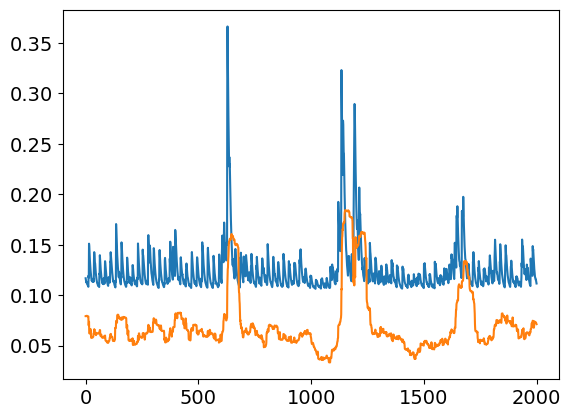

In [162]:
plt.plot(feat_gjr_garch_norm_24[2000:4000].values)
plt.plot(rv[4950:6950])

## Load LSTM preds

In [143]:
lstm_preds_1 = pd.read_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_1_new.csv')
lstm_preds_arch_norm_1 = pd.read_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_arch_norm_1_new.csv')
lstm_preds_arch_std_1 = pd.read_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_arch_std_1_new.csv') 
lstm_preds_arch_ged_1 = pd.read_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_arch_ged_1_new.csv') 
lstm_preds_garch_norm_1 = pd.read_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_garch_norm_1_new.csv') 
lstm_preds_garch_std_1 = pd.read_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_garch_std_1_new.csv') 
lstm_preds_garch_ged_1 = pd.read_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_garch_ged_1_new.csv') 
lstm_preds_egarch_norm_1 = pd.read_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_egarch_norm_1_new.csv') 
lstm_preds_egarch_std_1 = pd.read_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_egarch_std_1_new.csv') 
lstm_preds_egarch_ged_1 = pd.read_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_egarch_ged_1_new.csv')
lstm_preds_gjrgarch_norm_1 = pd.read_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_gjrgarch_norm_1_new.csv')
lstm_preds_gjrgarch_std_1 = pd.read_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_gjrgarch_std_1_new.csv') 
lstm_preds_gjrgarch_ged_1 = pd.read_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_gjrgarch_ged_1_new.csv')
lstm_preds_msgarch_norm_1 = pd.read_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_msgarch_norm_1_new.csv')
lstm_preds_msgarch_std_1 = pd.read_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_msgarch_std_1_new.csv') 
lstm_preds_msgarch_ged_1 = pd.read_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_msgarch_ged_1_new.csv')

In [144]:
lstm_preds_12 = pd.read_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_12_new.csv')
lstm_preds_arch_norm_12 = pd.read_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_arch_norm_12_new.csv')
lstm_preds_arch_std_12 = pd.read_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_arch_std_12_new.csv') 
lstm_preds_arch_ged_12 = pd.read_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_arch_ged_12_new.csv') 
lstm_preds_garch_norm_12 = pd.read_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_garch_norm_12_new.csv') 
lstm_preds_garch_std_12 = pd.read_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_garch_std_12_new.csv') 
lstm_preds_garch_ged_12 = pd.read_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_garch_ged_12_new.csv') 
lstm_preds_egarch_norm_12 = pd.read_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_egarch_norm_12_new.csv') 
lstm_preds_egarch_std_12 = pd.read_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_egarch_std_12_new.csv') 
lstm_preds_egarch_ged_12 = pd.read_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_egarch_ged_12_new.csv')
lstm_preds_gjrgarch_norm_12 = pd.read_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_gjrgarch_norm_12_new.csv')
lstm_preds_gjrgarch_std_12 = pd.read_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_gjrgarch_std_12_new.csv') 
lstm_preds_gjrgarch_ged_12 = pd.read_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_gjrgarch_ged_12_new.csv')
lstm_preds_msgarch_norm_12 = pd.read_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_msgarch_norm_12_new.csv')
lstm_preds_msgarch_std_12 = pd.read_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_msgarch_std_12_new.csv') 
lstm_preds_msgarch_ged_12 = pd.read_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_msgarch_ged_12_new.csv')

In [145]:
lstm_preds_24 = pd.read_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_24_new.csv')
lstm_preds_arch_norm_24 = pd.read_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_arch_norm_24_new.csv')
lstm_preds_arch_std_24 = pd.read_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_arch_std_24_new.csv') 
lstm_preds_arch_ged_24 = pd.read_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_arch_ged_24_new.csv') 
lstm_preds_garch_norm_24 = pd.read_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_garch_norm_24_new.csv') 
lstm_preds_garch_std_24 = pd.read_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_garch_std_24_new.csv') 
lstm_preds_garch_ged_24 = pd.read_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_garch_ged_24_new.csv') 
lstm_preds_egarch_norm_24 = pd.read_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_egarch_norm_24_new.csv') 
lstm_preds_egarch_std_24 = pd.read_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_egarch_std_24_new.csv') 
lstm_preds_egarch_ged_24 = pd.read_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_egarch_ged_24_new.csv')
lstm_preds_gjrgarch_norm_24 = pd.read_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_gjrgarch_norm_24_new.csv')
lstm_preds_gjrgarch_std_24 = pd.read_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_gjrgarch_std_24_new.csv') 
lstm_preds_gjrgarch_ged_24 = pd.read_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_gjrgarch_ged_24_new.csv')
lstm_preds_msgarch_norm_24 = pd.read_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_msgarch_norm_24_new.csv')
lstm_preds_msgarch_std_24 = pd.read_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_msgarch_std_24_new.csv') 
lstm_preds_msgarch_ged_24 = pd.read_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_msgarch_ged_24_new.csv')

## 3. Error calculations conditional volatility models

In [146]:
rv = rv_calc(log_returns, h = 50)

In [147]:
obs_test = 20000
start = 10000
d = 150
h = 1

In [38]:
MSE_arch_norm_1, MAE_arch_norm_1, MSE_arch_std_1, MAE_arch_std_1, MSE_arch_ged_1, MAE_arch_ged_1 = calc_errors(rv, obs_test, preds_arch_norm_1, preds_arch_std_1, preds_arch_ged_1)
MSE_garch_norm_1, MAE_garch_norm_1, MSE_garch_std_1, MAE_garch_std_1, MSE_garch_ged_1, MAE_garch_ged_1 = calc_errors(rv, obs_test, preds_garch_norm_1, preds_garch_std_1, preds_garch_ged_1)
MSE_egarch_norm_1, MAE_egarch_norm_1, MSE_egarch_std_1, MAE_egarch_std_1, MSE_egarch_ged_1, MAE_egarch_ged_1 = calc_errors(rv, obs_test, preds_e_garch_norm_1, preds_e_garch_std_1, preds_e_garch_ged_1)
MSE_gjrgarch_norm_1, MAE_gjrgarch_norm_1, MSE_gjrgarch_std_1, MAE_gjrgarch_std_1, MSE_gjrgarch_ged_1, MAE_gjrgarch_ged_1 = calc_errors(rv, obs_test, preds_gjr_garch_norm_1, preds_gjr_garch_std_1, preds_gjr_garch_ged_1)
MSE_msgarch_norm_1, MAE_msgarch_norm_1, MSE_msgarch_std_1, MAE_msgarch_std_1, MSE_msgarch_ged_1, MAE_msgarch_ged_1 = calc_errors(rv, obs_test, preds_ms_garch_norm_1, preds_ms_garch_std_1, preds_ms_garch_ged_1)

MSE_arch_norm_12, MAE_arch_norm_12, MSE_arch_std_12, MAE_arch_std_12, MSE_arch_ged_12, MAE_arch_ged_12 = calc_errors(rv, obs_test, preds_arch_norm_12, preds_arch_std_12, preds_arch_ged_12)
MSE_garch_norm_12, MAE_garch_norm_12, MSE_garch_std_12, MAE_garch_std_12, MSE_garch_ged_12, MAE_garch_ged_12 = calc_errors(rv, obs_test, preds_garch_norm_12, preds_garch_std_12, preds_garch_ged_12)
MSE_egarch_norm_12, MAE_egarch_norm_12, MSE_egarch_std_12, MAE_egarch_std_12, MSE_egarch_ged_12, MAE_egarch_ged_12 = calc_errors(rv, obs_test, preds_e_garch_norm_12, preds_e_garch_std_12, preds_e_garch_ged_12)
MSE_gjrgarch_norm_12, MAE_gjrgarch_norm_12, MSE_gjrgarch_std_12, MAE_gjrgarch_std_12, MSE_gjrgarch_ged_12, MAE_gjrgarch_ged_12 = calc_errors(rv, obs_test, preds_gjr_garch_norm_12, preds_gjr_garch_std_12, preds_gjr_garch_ged_12)
MSE_msgarch_norm_12, MAE_msgarch_norm_12, MSE_msgarch_std_12, MAE_msgarch_std_12, MSE_msgarch_ged_12, MAE_msgarch_ged_12 = calc_errors(rv, obs_test, preds_ms_garch_norm_12, preds_ms_garch_std_12, preds_ms_garch_ged_12)

MSE_arch_norm_24, MAE_arch_norm_24, MSE_arch_std_24, MAE_arch_std_24, MSE_arch_ged_24, MAE_arch_ged_24 = calc_errors(rv, obs_test, preds_arch_norm_24, preds_arch_std_24, preds_arch_ged_24)
MSE_garch_norm_24, MAE_garch_norm_24, MSE_garch_std_24, MAE_garch_std_24, MSE_garch_ged_24, MAE_garch_ged_24 = calc_errors(rv, obs_test, preds_garch_norm_24, preds_garch_std_24, preds_garch_ged_24)
MSE_egarch_norm_24, MAE_egarch_norm_24, MSE_egarch_std_24, MAE_egarch_std_24, MSE_egarch_ged_24, MAE_egarch_ged_24 = calc_errors(rv, obs_test, preds_e_garch_norm_24, preds_e_garch_std_24, preds_e_garch_ged_24)
MSE_gjrgarch_norm_24, MAE_gjrgarch_norm_24, MSE_gjrgarch_std_24, MAE_gjrgarch_std_24, MSE_gjrgarch_ged_24, MAE_gjrgarch_ged_24 = calc_errors(rv, obs_test, preds_gjr_garch_norm_24, preds_gjr_garch_std_24, preds_gjr_garch_ged_24)
MSE_msgarch_norm_24, MAE_msgarch_norm_24, MSE_msgarch_std_24, MAE_msgarch_std_24, MSE_msgarch_ged_24, MAE_msgarch_ged_24 = calc_errors(rv, obs_test, preds_ms_garch_norm_24, preds_ms_garch_std_24, preds_ms_garch_ged_24)

data = {
    'Distribution': ['Normal', 'Normal', 'Normal', 'Normal', 'Normal',  
                     'Student-t', 'Student-t', 'Student-t', 'Student-t', 'Student-t',
                     'GED', 'GED', 'GED', 'GED', 'GED'],
    'Model:': [ 'ARCH', 'GARCH', 'E-GARCH', 'GJR-GARCH', 'MS-GARCH',
               'ARCH', 'GARCH', 'E-GARCH', 'GJR-GARCH', 'MS-GARCH',
              'ARCH', 'GARCH', 'E-GARCH', 'GJR-GARCH', 'MS-GARCH'],
    'MSE_h=1': [MSE_arch_norm_1, MSE_garch_norm_1, MSE_egarch_norm_1, MSE_gjrgarch_norm_1,  MSE_msgarch_norm_1, 
                MSE_arch_std_1, MSE_garch_std_1, MSE_egarch_std_1, MSE_gjrgarch_std_1,  MSE_msgarch_std_1,
                MSE_arch_ged_1, MSE_garch_ged_1, MSE_egarch_ged_1, MSE_gjrgarch_ged_1,  MSE_msgarch_ged_1],
    'MSE_h=12': [MSE_arch_norm_12, MSE_garch_norm_12, MSE_egarch_norm_12, MSE_gjrgarch_norm_12,  MSE_msgarch_norm_12, 
                 MSE_arch_std_12, MSE_garch_std_12, MSE_egarch_std_12, MSE_gjrgarch_std_12,  MSE_msgarch_std_12,
                 MSE_arch_ged_12, MSE_garch_ged_12, MSE_egarch_ged_12, MSE_gjrgarch_ged_12,  MSE_msgarch_ged_12],
    'MSE_h=24': [MSE_arch_norm_24, MSE_garch_norm_24, MSE_egarch_norm_24, MSE_gjrgarch_norm_24,  MSE_msgarch_norm_24, 
                 MSE_arch_std_24, MSE_garch_std_24, MSE_egarch_std_24, MSE_gjrgarch_std_24,  MSE_msgarch_std_24,
                 MSE_arch_ged_24, MSE_garch_ged_24, MSE_egarch_ged_24, MSE_gjrgarch_ged_24,  MSE_msgarch_ged_24],
    'MAE_h=1': [MAE_arch_norm_1, MAE_garch_norm_1, MAE_egarch_norm_1, MAE_gjrgarch_norm_1,  MAE_msgarch_norm_1, 
                MAE_arch_std_1, MAE_garch_std_1, MAE_egarch_std_1, MAE_gjrgarch_std_1,  MAE_msgarch_std_1,
                MAE_arch_ged_1, MAE_garch_ged_1, MAE_egarch_ged_1, MAE_gjrgarch_ged_1,  MAE_msgarch_ged_1],
    'MAE_h=12': [MAE_arch_norm_12, MAE_garch_norm_12, MAE_egarch_norm_12, MAE_gjrgarch_norm_12,  MAE_msgarch_norm_12, 
                 MAE_arch_std_12, MAE_garch_std_12, MAE_egarch_std_12, MAE_gjrgarch_std_12,  MAE_msgarch_std_12,
                 MAE_arch_ged_12, MAE_garch_ged_12, MAE_egarch_ged_12, MAE_gjrgarch_ged_12,  MAE_msgarch_ged_12],
    'MAE_h=24': [MAE_arch_norm_24, MAE_garch_norm_24, MAE_egarch_norm_24, MAE_gjrgarch_norm_24,  MAE_msgarch_norm_24, 
                 MAE_arch_std_24, MAE_garch_std_24, MAE_egarch_std_24, MAE_gjrgarch_std_24,  MAE_msgarch_std_24,
                 MAE_arch_ged_24, MAE_garch_ged_24, MAE_egarch_ged_24, MAE_gjrgarch_ged_24,  MAE_msgarch_ged_24]
}

df = pd.DataFrame(data)
print(df)

# Convert numpy array to LaTeX table
latex_table = tabulate(df, tablefmt="latex")

print(latex_table)

   Distribution     Model:   MSE_h=1  MSE_h=12  MSE_h=24   MAE_h=1  MAE_h=12  \
0        Normal       ARCH  0.035221  0.035191  0.047559  0.088864  0.097012   
1        Normal      GARCH  0.014087  0.006975  0.007866  0.054386  0.037840   
2        Normal    E-GARCH  0.013123  0.009218  0.007072  0.051520  0.047133   
3        Normal  GJR-GARCH  0.013292  0.009710  0.008688  0.053083  0.045070   
4        Normal   MS-GARCH  0.043034  0.014909  0.014307  0.098878  0.059178   
5     Student-t       ARCH  0.041558  0.037539  0.051660  0.094542  0.098412   
6     Student-t      GARCH  0.034664  0.036148  0.049168  0.087284  0.095221   
7     Student-t    E-GARCH  0.016107  0.012090  0.007750  0.055069  0.054073   
8     Student-t  GJR-GARCH  0.021314  0.019940  0.019081  0.067409  0.066118   
9     Student-t   MS-GARCH  0.041648  0.013730  0.010461  0.096828  0.053026   
10          GED       ARCH  0.041428  0.045942  0.046738  0.094186  0.141320   
11          GED      GARCH  0.032438  0.

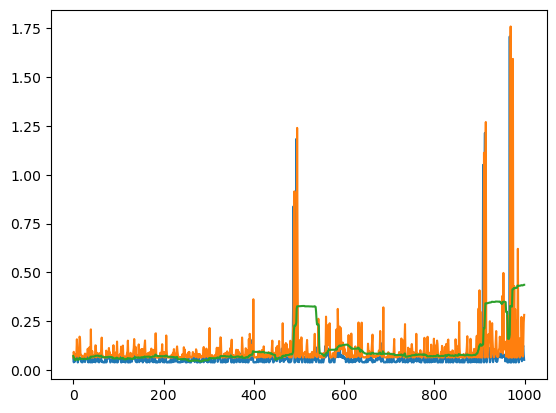

In [53]:
plt.plot(preds_ms_garch_norm_1[0:1000])
plt.plot(preds_arch_norm_1[0:1000])
plt.plot(rv[(len(rv)-20000):(len(rv)-19000)])

In [52]:
print(mse(rv[(len(rv)-20000):(len(rv))], preds_ms_garch_norm_1))
print(mse(rv[(len(rv)-20000):(len(rv))], preds_arch_norm_1))

0.04303405294218654
0.035220521106941474


# 4. LSTM model 

## 4.1 Electricity price data

### 4.1.1 1-Step ahead 

In [20]:
obs_test = 20000
start = 10000
d = 50
h = 1
epochs = 75
units = 125
nodes = 150
verbose = 0
dropout_rate = 0.1
LR = 0.0001
activation_lstm = 'tanh'
shift = 5

In [21]:
#Create equal lengths
diff = len(rv) - len(feat_arch_norm_1)
rv = rv[diff:]
# Scale realized volatility
scaled_rv = scaled_data(rv)
scaled_rv = scaled_rv.flatten()
rv = rv.flatten()

NameError: name 'feat_arch_norm_1' is not defined

In [85]:
# Scale and flatten all features
scaled_feat_arch_norm_1 = scaled_data(np.array(feat_arch_norm_1)).flatten()
scaled_feat_arch_std_1 = scaled_data(np.array(feat_arch_std_1)).flatten()
scaled_feat_arch_ged_1 = scaled_data(np.array(feat_arch_ged_1)).flatten()
scaled_feat_garch_norm_1 = scaled_data(np.array(feat_garch_norm_1)).flatten()
scaled_feat_garch_std_1 = scaled_data(np.array(feat_garch_std_1)).flatten()
scaled_feat_garch_ged_1 = scaled_data(np.array(feat_garch_ged_1)).flatten()
scaled_feat_e_garch_norm_1 = scaled_data(np.array(feat_e_garch_norm_1)).flatten()
scaled_feat_e_garch_std_1 = scaled_data(np.array(feat_e_garch_std_1)).flatten()
scaled_feat_e_garch_ged_1 = scaled_data(np.array(feat_e_garch_ged_1)).flatten()
scaled_feat_gjr_garch_norm_1 = scaled_data(np.array(feat_gjr_garch_norm_1)).flatten()
scaled_feat_gjr_garch_std_1 = scaled_data(np.array(feat_gjr_garch_std_1)).flatten()
scaled_feat_gjr_garch_ged_1 = scaled_data(np.array(feat_gjr_garch_ged_1)).flatten()
scaled_feat_ms_garch_norm_1 = scaled_data(np.array(feat_ms_garch_norm_1)).flatten()
scaled_feat_ms_garch_std_1 = scaled_data(np.array(feat_ms_garch_std_1)).flatten()
scaled_feat_ms_garch_ged_1 = scaled_data(np.array(feat_ms_garch_ged_1)).flatten()

In [26]:
lstm_preds_1 = univariate_lstm_preds_shift(scaled_rv, obs_test, start, d, h, epochs, units, nodes, verbose, LR, activation_lstm, rv, shift)
lstm_preds_arch_norm_1 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_arch_norm_1, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_arch_std_1 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_arch_std_1,  obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_arch_ged_1 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_arch_ged_1, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_garch_norm_1 = generate_2_forecasts_hybrid_shift(scaled_rv,scaled_feat_garch_norm_1, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_garch_std_1 = generate_2_forecasts_hybrid_shift(scaled_rv,scaled_feat_garch_std_1, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_garch_ged_1 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_garch_ged_1, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_egarch_norm_1 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_e_garch_norm_1, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_egarch_std_1 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_e_garch_std_1, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_egarch_ged_1 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_e_garch_ged_1, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_gjrgarch_norm_1 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_gjr_garch_norm_1, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_gjrgarch_std_1 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_gjr_garch_std_1, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_gjrgarch_ged_1 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_gjr_garch_ged_1, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)

2023-06-26 12:46:40.976774: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


KeyboardInterrupt: 

In [139]:
lstm_preds_msgarch_norm_1 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_ms_garch_norm_1, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_msgarch_std_1 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_ms_garch_std_1, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_msgarch_ged_1 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_ms_garch_ged_1, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)

313/313 [==============================] - 15s 47ms/step


KeyboardInterrupt: 

In [77]:
mse_lstm_1 = mse(lstm_preds_1, rv[(len(rv) - obs_test):len(rv)])
mse_lstm_arch_norm_1 = mse(lstm_preds_arch_norm_1, rv[(len(rv) - obs_test):len(rv)])
mse_lstm_arch_std_1 = mse(lstm_preds_arch_std_1, rv[(len(rv) - obs_test):len(rv)])
mse_lstm_arch_ged_1 = mse(lstm_preds_arch_ged_1, rv[(len(rv) - obs_test):len(rv)])
mse_lstm_garch_norm_1 = mse(lstm_preds_garch_norm_1, rv[(len(rv) - obs_test):len(rv)])
mse_lstm_garch_std_1 = mse(lstm_preds_garch_std_1, rv[(len(rv) - obs_test):len(rv)])
mse_lstm_garch_ged_1 = mse(lstm_preds_garch_ged_1, rv[(len(rv) - obs_test):len(rv)])
mse_lstm_egarch_norm_1 = mse(lstm_preds_egarch_norm_1, rv[(len(rv) - obs_test):len(rv)])
mse_lstm_egarch_std_1 = mse(lstm_preds_egarch_std_1, rv[(len(rv) - obs_test):len(rv)])
mse_lstm_egarch_ged_1 = mse(lstm_preds_egarch_ged_1, rv[(len(rv) - obs_test):len(rv)])
mse_lstm_gjrgarch_norm_1 = mse(lstm_preds_gjrgarch_norm_1, rv[(len(rv) - obs_test):len(rv)])
mse_lstm_gjrgarch_std_1 = mse(lstm_preds_gjrgarch_std_1, rv[(len(rv) - obs_test):len(rv)])
mse_lstm_gjrgarch_ged_1 = mse(lstm_preds_gjrgarch_ged_1, rv[(len(rv) - obs_test):len(rv)])

mae_lstm_1 = mae(lstm_preds_1, rv[(len(rv) - obs_test):len(rv)])
mae_lstm_arch_norm_1 = mae(lstm_preds_arch_norm_1, rv[(len(rv) - obs_test):len(rv)])
mae_lstm_arch_std_1 = mae(lstm_preds_arch_std_1, rv[(len(rv) - obs_test):len(rv)])
mae_lstm_arch_ged_1 = mae(lstm_preds_arch_ged_1, rv[(len(rv) - obs_test):len(rv)])
mae_lstm_garch_norm_1 = mae(lstm_preds_garch_norm_1, rv[(len(rv) - obs_test):len(rv)])
mae_lstm_garch_std_1 = mae(lstm_preds_garch_std_1, rv[(len(rv) - obs_test):len(rv)])
mae_lstm_garch_ged_1 = mae(lstm_preds_garch_ged_1, rv[(len(rv) - obs_test):len(rv)])
mae_lstm_egarch_norm_1 = mae(lstm_preds_egarch_norm_1, rv[(len(rv) - obs_test):len(rv)])
mae_lstm_egarch_std_1 = mae(lstm_preds_egarch_std_1, rv[(len(rv) - obs_test):len(rv)])
mae_lstm_egarch_ged_1 = mae(lstm_preds_egarch_ged_1, rv[(len(rv) - obs_test):len(rv)])
mae_lstm_gjrgarch_norm_1 = mae(lstm_preds_gjrgarch_norm_1, rv[(len(rv) - obs_test):len(rv)])
mae_lstm_gjrgarch_std_1 = mae(lstm_preds_gjrgarch_std_1, rv[(len(rv) - obs_test):len(rv)])
mae_lstm_gjrgarch_ged_1 = mae(lstm_preds_gjrgarch_ged_1, rv[(len(rv) - obs_test):len(rv)])
mae_lstm_msgarch_norm_1 = mae(lstm_preds_msgarch_norm_1, rv[(len(rv) - obs_test):len(rv)])
mae_lstm_msgarch_std_1 = mae(lstm_preds_msgarch_std_1, rv[(len(rv) - obs_test):len(rv)])
mae_lstm_msgarch_ged_1 = mae(lstm_preds_msgarch_ged_1, rv[(len(rv) - obs_test):len(rv)])

NameError: name 'lstm_preds_1' is not defined

In [130]:
mse_lstm_msgarch_norm_1 = mse(lstm_preds_msgarch_norm_1, rv[(len(rv) - obs_test):len(rv)])
mse_lstm_msgarch_std_1 = mse(lstm_preds_msgarch_std_1, rv[(len(rv) - obs_test):len(rv)])
mse_lstm_msgarch_ged_1 = mse(lstm_preds_msgarch_ged_1, rv[(len(rv) - obs_test):len(rv)])

mae_lstm_msgarch_norm_1 = mae(lstm_preds_msgarch_norm_1, rv[(len(rv) - obs_test):len(rv)])
mae_lstm_msgarch_std_1 = mae(lstm_preds_msgarch_std_1, rv[(len(rv) - obs_test):len(rv)])
mae_lstm_msgarch_ged_1 = mae(lstm_preds_msgarch_ged_1, rv[(len(rv) - obs_test):len(rv)])

In [131]:
print(mse_lstm_msgarch_norm_1)
print(mse_lstm_msgarch_std_1)
print(mse_lstm_msgarch_ged_1)

print(mae_lstm_msgarch_norm_1)
print(mae_lstm_msgarch_std_1)
print(mae_lstm_msgarch_ged_1)

print(len(lstm_preds_msgarch_std_1))

0.00021894678186111874
0.00020452486645865752
0.00025314347287200273
0.005685058675762775
0.0057709174341428904
0.007983402107641922
20000


In [38]:
print(mse_lstm_1)
print(mse_lstm_arch_norm_1)
print(mse_lstm_arch_std_1)
print(mse_lstm_arch_ged_1)
print(mse_lstm_garch_norm_1) 
print(mse_lstm_garch_std_1)
print(mse_lstm_garch_ged_1)
print(mse_lstm_egarch_norm_1)
print(mse_lstm_egarch_std_1)
print(mse_lstm_egarch_ged_1) 
print(mse_lstm_gjrgarch_norm_1)
print(mse_lstm_gjrgarch_std_1) 
print(mse_lstm_gjrgarch_ged_1) 
print(mse_lstm_msgarch_norm_1) 

print(mae_lstm_1)
print(mae_lstm_arch_norm_1)
print(mae_lstm_arch_std_1)
print(mae_lstm_arch_ged_1)
print(mae_lstm_garch_norm_1) 
print(mae_lstm_garch_std_1)
print(mae_lstm_garch_ged_1)
print(mae_lstm_egarch_norm_1)
print(mae_lstm_egarch_std_1)
print(mae_lstm_egarch_ged_1) 
print(mae_lstm_gjrgarch_norm_1)
print(mae_lstm_gjrgarch_std_1) 
print(mae_lstm_gjrgarch_ged_1) 
print(mae_lstm_msgarch_norm_1) 
print(mae_lstm_msgarch_std_1)
print(mae_lstm_msgarch_ged_1)

0.0002800756780587856
0.00021871682674442825
0.00021628444791853686
0.00023249254737516974
0.0002613249628541054
0.00020767674402037762
0.00021157580924809652
0.00023070897393013743
0.00021675390191046895
0.00023683253379453415
0.00021266588656999112
0.00020087531904786716
0.00022494841632126779
0.0001265998737715661
0.00019447267777046278
0.00022160077454932522
0.0058174520219648135
0.004711284426140842
0.005480322333338628
0.0051928811122535536
0.005963090901125268
0.00492950181281948
0.004167166618775979
0.00428022606384152
0.005165975675051682
0.005754996515214618
0.004394518729753269
0.004848842914933643
0.0053216807964693745
0.0031278885272218236
0.004631402175000875
0.0057515942663092295


### 4.1.2 12-step ahead

In [120]:
h = 12
d = 250
epochs = 75
units = 125
nodes = 150
dropout_rate = 0.1
shift = 5
LR = 0.0001
activation_lstm = 'tanh'

In [121]:
# Scale and flatten all features
scaled_feat_arch_norm_12 = scaled_data(np.array(feat_arch_norm_12)).flatten()
scaled_feat_arch_std_12 = scaled_data(np.array(feat_arch_std_12)).flatten()
scaled_feat_arch_ged_12 = scaled_data(np.array(feat_arch_ged_12)).flatten()
scaled_feat_garch_norm_12 = scaled_data(np.array(feat_garch_norm_12)).flatten()
scaled_feat_garch_std_12 = scaled_data(np.array(feat_garch_std_12)).flatten()
scaled_feat_garch_ged_12 = scaled_data(np.array(feat_garch_ged_12)).flatten()
scaled_feat_e_garch_norm_12 = scaled_data(np.array(feat_e_garch_norm_12)).flatten()
scaled_feat_e_garch_std_12 = scaled_data(np.array(feat_e_garch_std_12)).flatten()
scaled_feat_e_garch_ged_12 = scaled_data(np.array(feat_e_garch_ged_12)).flatten()
scaled_feat_gjr_garch_norm_12 = scaled_data(np.array(feat_gjr_garch_norm_12)).flatten()
scaled_feat_gjr_garch_std_12 = scaled_data(np.array(feat_gjr_garch_std_12)).flatten()
scaled_feat_gjr_garch_ged_12 = scaled_data(np.array(feat_gjr_garch_ged_12)).flatten()
scaled_feat_ms_garch_norm_12 = scaled_data(np.array(feat_ms_garch_norm_12)).flatten()
scaled_feat_ms_garch_std_12 = scaled_data(np.array(feat_ms_garch_std_12)).flatten()
scaled_feat_ms_garch_ged_12 = scaled_data(np.array(feat_ms_garch_ged_12)).flatten()

In [67]:
lstm_preds_12 = univariate_lstm_preds_shift(scaled_rv, obs_test, start, d, h, epochs, units, nodes, verbose, LR, activation_lstm, rv, shift)
lstm_preds_arch_norm_12 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_arch_norm_12, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_arch_std_12 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_arch_std_12,  obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_arch_ged_12 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_arch_ged_12, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)

313/313 [==============================] - 28s 89ms/step


In [68]:
lstm_preds_garch_norm_12 = generate_2_forecasts_hybrid_shift(scaled_rv,scaled_feat_garch_norm_12, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_garch_std_12 = generate_2_forecasts_hybrid_shift(scaled_rv,scaled_feat_garch_std_12, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_garch_ged_12 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_garch_ged_12, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_egarch_norm_12 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_e_garch_norm_12, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_egarch_std_12 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_e_garch_std_12, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_egarch_ged_12 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_e_garch_ged_12, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_gjrgarch_norm_12 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_gjr_garch_norm_12, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_gjrgarch_std_12 =  generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_gjr_garch_std_12, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_gjrgarch_ged_12 =  generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_gjr_garch_ged_12, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)

313/313 [==============================] - 26s 83ms/step


In [ ]:
lstm_preds_msgarch_norm_12 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_ms_garch_norm_12, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_msgarch_std_12 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_ms_garch_std_12, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_msgarch_ged_12 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_ms_garch_ged_12, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)

In [15]:
lstm_preds_msgarch_norm_12 = create_h_step_forecasts(lstm_preds_msgarch_norm_12, h, obs_test)
lstm_preds_msgarch_std_12 = create_h_step_forecasts(lstm_preds_msgarch_std_12, h, obs_test)
lstm_preds_msgarch_ged_12 = create_h_step_forecasts(lstm_preds_msgarch_ged_12, h, obs_test)

In [124]:
diff_12 = 4
mse_lstm_msgarch_norm_12 = mse(lstm_preds_msgarch_norm_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mse_lstm_msgarch_std_12 = mse(lstm_preds_msgarch_std_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mse_lstm_msgarch_ged_12 = mse(lstm_preds_msgarch_ged_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])

In [38]:
lstm_preds_12 = lstm_preds_12.values
lstm_preds_arch_norm_12 = lstm_preds_arch_norm_12.values
lstm_preds_arch_std_12 = lstm_preds_arch_std_12.values
lstm_preds_arch_ged_12 = lstm_preds_arch_ged_12.values
lstm_preds_garch_norm_12 = lstm_preds_garch_norm_12.values
lstm_preds_garch_std_12 = lstm_preds_garch_std_12.values
lstm_preds_garch_ged_12 = lstm_preds_garch_ged_12.values
lstm_preds_egarch_norm_12 = lstm_preds_egarch_norm_12.values
lstm_preds_egarch_std_12 = lstm_preds_egarch_std_12.values
lstm_preds_egarch_ged_12 = lstm_preds_egarch_ged_12.values
lstm_preds_gjrmsgarch_norm_12 = lstm_preds_gjrgarch_norm_12.values
lstm_preds_gjrmsgarch_std_12 = lstm_preds_gjrgarch_std_12.values
lstm_preds_gjrmsgarch_ged_12 = lstm_preds_gjrgarch_ged_12.values
lstm_preds_msgarch_norm_12 = lstm_preds_msgarch_norm_12.values
lstm_preds_msgarch_std_12 = lstm_preds_msgarch_std_12.values
lstm_preds_msgarch_ged_12 = lstm_preds_msgarch_ged_12.values

In [69]:
lstm_preds_12 = create_h_step_forecasts(lstm_preds_12, h, obs_test)
lstm_preds_arch_norm_12 = create_h_step_forecasts(lstm_preds_arch_norm_12, h, obs_test)
lstm_preds_arch_std_12 = create_h_step_forecasts(lstm_preds_arch_std_12, h, obs_test)
lstm_preds_arch_ged_12 = create_h_step_forecasts(lstm_preds_arch_ged_12, h, obs_test)

In [ ]:
lstm_preds_garch_norm_12 = create_h_step_forecasts(lstm_preds_garch_norm_12, h, obs_test)
lstm_preds_garch_std_12 = create_h_step_forecasts(lstm_preds_garch_std_12, h, obs_test)
lstm_preds_garch_ged_12 = create_h_step_forecasts(lstm_preds_garch_ged_12, h, obs_test)
lstm_preds_egarch_norm_12 = create_h_step_forecasts(lstm_preds_egarch_norm_12, h, obs_test)
lstm_preds_egarch_std_12 = create_h_step_forecasts(lstm_preds_egarch_std_12, h, obs_test)
lstm_preds_egarch_ged_12 = create_h_step_forecasts(lstm_preds_egarch_ged_12, h, obs_test)
lstm_preds_gjrgarch_norm_12 = create_h_step_forecasts(lstm_preds_gjrgarch_norm_12, h, obs_test)
lstm_preds_gjrgarch_std_12 = create_h_step_forecasts(lstm_preds_gjrgarch_std_12, h, obs_test)
lstm_preds_gjrgarch_ged_12 = create_h_step_forecasts(lstm_preds_gjrgarch_ged_12, h, obs_test)

In [70]:
lstm_preds_msgarch_norm_12 = create_h_step_forecasts(lstm_preds_msgarch_norm_12, h, obs_test)
lstm_preds_msgarch_std_12 = create_h_step_forecasts(lstm_preds_msgarch_std_12, h, obs_test)
lstm_preds_msgarch_ged_12 = create_h_step_forecasts(lstm_preds_msgarch_ged_12, h, obs_test)

In [16]:
mse_lstm_12 = mse(lstm_preds_12[:-4], rv[(len(rv) - obs_test):len(rv)])
mse_lstm_arch_norm_12 = mse(lstm_preds_arch_norm_12[:-4], rv[(len(rv) - obs_test):len(rv)])

NameError: name 'lstm_preds_12' is not defined

In [71]:
mse_lstm_arch_std_12 = mse(lstm_preds_arch_std_12[:-4], rv[(len(rv) - obs_test):len(rv)])
mse_lstm_arch_ged_12 = mse(lstm_preds_arch_ged_12[:-4], rv[(len(rv) - obs_test):len(rv)])

In [72]:
mse_lstm_garch_norm_12 = mse(lstm_preds_garch_norm_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mse_lstm_garch_std_12 = mse(lstm_preds_garch_std_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mse_lstm_garch_ged_12 = mse(lstm_preds_garch_ged_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mse_lstm_egarch_norm_12 = mse(lstm_preds_egarch_norm_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mse_lstm_egarch_std_12 = mse(lstm_preds_egarch_std_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mse_lstm_egarch_ged_12 = mse(lstm_preds_egarch_ged_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mse_lstm_gjrgarch_norm_12 = mse(lstm_preds_gjrgarch_norm_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mse_lstm_gjrgarch_std_12 = mse(lstm_preds_gjrgarch_std_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mse_lstm_gjrgarch_ged_12 = mse(lstm_preds_gjrgarch_ged_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mse_lstm_msgarch_norm_12 = mse(lstm_preds_msgarch_norm_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mse_lstm_msgarch_std_12 = mse(lstm_preds_msgarch_std_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mse_lstm_msgarch_ged_12 = mse(lstm_preds_msgarch_ged_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])

mae_lstm_12 = mae(lstm_preds_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mae_lstm_arch_norm_12 = mae(lstm_preds_arch_norm_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mae_lstm_arch_std_12 = mae(lstm_preds_arch_std_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mae_lstm_arch_ged_12 = mae(lstm_preds_arch_ged_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mae_lstm_garch_norm_12 = mae(lstm_preds_garch_norm_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mae_lstm_garch_std_12 = mae(lstm_preds_garch_std_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mae_lstm_garch_ged_12 = mae(lstm_preds_garch_ged_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mae_lstm_egarch_norm_12 = mae(lstm_preds_egarch_norm_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mae_lstm_egarch_std_12 = mae(lstm_preds_egarch_std_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mae_lstm_egarch_ged_12 = mae(lstm_preds_egarch_ged_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mae_lstm_gjrgarch_norm_12 = mae(lstm_preds_gjrgarch_norm_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mae_lstm_gjrgarch_std_12 = mae(lstm_preds_gjrgarch_std_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mae_lstm_gjrgarch_ged_12 = mae(lstm_preds_gjrgarch_ged_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mae_lstm_msgarch_norm_12 = mae(lstm_preds_msgarch_norm_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mae_lstm_msgarch_std_12 = mae(lstm_preds_msgarch_std_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mae_lstm_msgarch_ged_12 = mae(lstm_preds_msgarch_ged_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])

In [125]:
print(mse_lstm_12)
print(mse_lstm_arch_norm_12)
print(mse_lstm_arch_std_12)
print(mse_lstm_arch_ged_12)
print(mse_lstm_garch_norm_12) 
print(mse_lstm_garch_std_12)
print(mse_lstm_garch_ged_12)
print(mse_lstm_egarch_norm_12)
print(mse_lstm_egarch_std_12)
print(mse_lstm_egarch_ged_12) 
print(mse_lstm_gjrgarch_norm_12)
print(mse_lstm_gjrgarch_std_12) 
print(mse_lstm_gjrgarch_ged_12) 
print(mse_lstm_msgarch_norm_12) 
print(mse_lstm_msgarch_std_12)
print(mse_lstm_msgarch_ged_12)
print('-')
print(mae_lstm_12)
print(mae_lstm_arch_norm_12)
print(mae_lstm_arch_std_12)
print(mae_lstm_arch_ged_12)
print(mae_lstm_garch_norm_12) 
print(mae_lstm_garch_std_12)
print(mae_lstm_garch_ged_12)
print(mae_lstm_egarch_norm_12)
print(mae_lstm_egarch_std_12)
print(mae_lstm_egarch_ged_12) 
print(mae_lstm_gjrgarch_norm_12)
print(mae_lstm_gjrgarch_std_12) 
print(mae_lstm_gjrgarch_ged_12) 
print(mae_lstm_msgarch_norm_12) 
print(mae_lstm_msgarch_std_12)
print(mae_lstm_msgarch_ged_12)

0.002023891494939945
0.001537594301738543
0.0016041376428079697
0.002090683140188344
0.0016248684395355059
0.0016226916221119393
0.0015244512675701692
0.0014087782385200623
0.0014831580435743959
0.0015123139219791167
0.0012451937183984955
0.00162557636789017
0.0013919179986208686
0.0013420745715770708
0.0019448107073543894
0.0015798756125815843
-
0.01984466301316139
0.016663088028649707
0.016095029972733245
0.019215363336472252
0.017605737543247874
0.016391650411833922
0.016498917833433484
0.015073690938139175
0.016611538932967216
0.0175130890385207
0.014251217323776643
0.0181240658691232
0.015713004809015097
0.015476419820151634
0.04
0.04


### 4.1.3 24-step ahead

In [145]:
h = 24
d = 400
epochs = 75
units = 100
nodes = 125
dropout_rate = 0.1
shift = 10
LR = 0.0001
activation_lstm = 'tanh'

In [146]:
# Scale and flatten all features
scaled_feat_arch_norm_24 = scaled_data(np.array(feat_arch_norm_24)).flatten()
scaled_feat_arch_std_24 = scaled_data(np.array(feat_arch_std_24)).flatten()
scaled_feat_arch_ged_24 = scaled_data(np.array(feat_arch_ged_24)).flatten()
scaled_feat_garch_norm_24 = scaled_data(np.array(feat_garch_norm_24)).flatten()
scaled_feat_garch_std_24 = scaled_data(np.array(feat_garch_std_24)).flatten()
scaled_feat_garch_ged_24 = scaled_data(np.array(feat_garch_ged_24)).flatten()
scaled_feat_e_garch_norm_24 = scaled_data(np.array(feat_e_garch_norm_24)).flatten()
scaled_feat_e_garch_std_24 = scaled_data(np.array(feat_e_garch_std_24)).flatten()
scaled_feat_e_garch_ged_24 = scaled_data(np.array(feat_e_garch_ged_24)).flatten()
scaled_feat_gjr_garch_norm_24 = scaled_data(np.array(feat_gjr_garch_norm_24)).flatten()
scaled_feat_gjr_garch_std_24 = scaled_data(np.array(feat_gjr_garch_std_24)).flatten()
scaled_feat_gjr_garch_ged_24 = scaled_data(np.array(feat_gjr_garch_ged_24)).flatten()
scaled_feat_ms_garch_norm_24 = scaled_data(np.array(feat_ms_garch_norm_24)).flatten()
scaled_feat_ms_garch_std_24 = scaled_data(np.array(feat_ms_garch_std_24)).flatten()
scaled_feat_ms_garch_ged_24 = scaled_data(np.array(feat_ms_garch_ged_24)).flatten()

In [49]:
lstm_preds_24 = univariate_lstm_preds_shift(scaled_rv, obs_test, start, d, h, epochs, units, nodes, verbose, LR, activation_lstm, rv, shift)
lstm_preds_arch_norm_24 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_arch_norm_24, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_arch_std_24 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_arch_std_24,  obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_arch_ged_24 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_arch_ged_24, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_garch_norm_24 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_garch_norm_24, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_garch_std_24 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_garch_std_24, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_garch_ged_24 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_garch_ged_24, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_egarch_norm_24 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_e_garch_norm_24, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_egarch_std_24 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_e_garch_std_24, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_egarch_ged_24 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_e_garch_ged_24, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_gjrgarch_norm_24 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_gjr_garch_norm_24, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_gjrgarch_std_24 =  generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_gjr_garch_std_24, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_gjrgarch_ged_24 =  generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_gjr_garch_ged_24, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)

313/313 [==============================] - 36s 113ms/step


In [ ]:
lstm_preds_msgarch_norm_24 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_ms_garch_norm_24, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)

In [76]:
lstm_preds_msgarch_std_24 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_ms_garch_std_24, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)
lstm_preds_msgarch_ged_24 = generate_2_forecasts_hybrid_shift(scaled_rv, scaled_feat_ms_garch_ged_24, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h, shift)

313/313 [==============================] - 29s 92ms/step


In [50]:
lstm_preds_24 = create_h_step_forecasts(lstm_preds_24, h, obs_test)
lstm_preds_arch_norm_24 = create_h_step_forecasts(lstm_preds_arch_norm_24, h, obs_test)
lstm_preds_arch_std_24 = create_h_step_forecasts(lstm_preds_arch_std_24, h, obs_test)
lstm_preds_arch_ged_24 = create_h_step_forecasts(lstm_preds_arch_ged_24, h, obs_test)
lstm_preds_garch_norm_24 = create_h_step_forecasts(lstm_preds_garch_norm_24, h, obs_test)
lstm_preds_garch_std_24 = create_h_step_forecasts(lstm_preds_garch_std_24, h, obs_test)
lstm_preds_garch_ged_24 = create_h_step_forecasts(lstm_preds_garch_ged_24, h, obs_test)
lstm_preds_egarch_norm_24 = create_h_step_forecasts(lstm_preds_egarch_norm_24, h, obs_test)
lstm_preds_egarch_std_24 = create_h_step_forecasts(lstm_preds_egarch_std_24, h, obs_test)
lstm_preds_egarch_ged_24 = create_h_step_forecasts(lstm_preds_egarch_ged_24, h, obs_test)
lstm_preds_gjrgarch_norm_24 = create_h_step_forecasts(lstm_preds_gjrgarch_norm_24, h, obs_test)
lstm_preds_gjrgarch_std_24 = create_h_step_forecasts(lstm_preds_gjrgarch_std_24, h, obs_test)
lstm_preds_gjrgarch_ged_24 = create_h_step_forecasts(lstm_preds_gjrgarch_ged_24, h, obs_test)

In [ ]:
lstm_preds_msgarch_norm_24 = create_h_step_forecasts(lstm_preds_msgarch_norm_24, h, obs_test)

In [98]:
lstm_preds_msgarch_std_24 = create_h_step_forecasts(lstm_preds_msgarch_std_24, h, obs_test)
lstm_preds_msgarch_ged_24 = create_h_step_forecasts(lstm_preds_msgarch_ged_24, h, obs_test)

In [101]:
#mse_lstm_msgarch_norm_24 = mse(lstm_preds_msgarch_norm_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mse_lstm_msgarch_std_24 = mse(lstm_preds_msgarch_std_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mse_lstm_msgarch_ged_24 = mse(lstm_preds_msgarch_ged_24, rv[(len(rv) - obs_test):(len(rv)-8)])

#mae_lstm_msgarch_norm_24 = mae(lstm_preds_msgarch_norm_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mae_lstm_msgarch_std_24 = mae(lstm_preds_msgarch_std_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mae_lstm_msgarch_ged_24 = mae(lstm_preds_msgarch_ged_24, rv[(len(rv) - obs_test):(len(rv)-8)])

In [102]:
print(mse_lstm_msgarch_std_24)
print(mse_lstm_msgarch_ged_24)
print(mae_lstm_msgarch_std_24)
print(mae_lstm_msgarch_ged_24)

0.004432246701800694
0.004978040639516057
0.03152006019680329
0.0310679241998786


In [51]:
mse_lstm_24 = mse(lstm_preds_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mse_lstm_arch_norm_24 = mse(lstm_preds_arch_norm_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mse_lstm_arch_std_24 = mse(lstm_preds_arch_std_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mse_lstm_arch_ged_24 = mse(lstm_preds_arch_ged_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mse_lstm_garch_norm_24 = mse(lstm_preds_garch_norm_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mse_lstm_garch_std_24 = mse(lstm_preds_garch_std_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mse_lstm_garch_ged_24 = mse(lstm_preds_garch_ged_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mse_lstm_egarch_norm_24 = mse(lstm_preds_egarch_norm_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mse_lstm_egarch_std_24 = mse(lstm_preds_egarch_std_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mse_lstm_egarch_ged_24 = mse(lstm_preds_egarch_ged_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mse_lstm_gjrgarch_norm_24 = mse(lstm_preds_gjrgarch_norm_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mse_lstm_gjrgarch_std_24 = mse(lstm_preds_gjrgarch_std_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mse_lstm_gjrgarch_ged_24 = mse(lstm_preds_gjrgarch_ged_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mse_lstm_msgarch_norm_24 = mse(lstm_preds_msgarch_norm_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mse_lstm_msgarch_std_24 = mse(lstm_preds_msgarch_std_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mse_lstm_msgarch_ged_24 = mse(lstm_preds_msgarch_ged_24, rv[(len(rv) - obs_test):(len(rv)-8)])

mae_lstm_24 = mae(lstm_preds_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mae_lstm_arch_norm_24 = mae(lstm_preds_arch_norm_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mae_lstm_arch_std_24 = mae(lstm_preds_arch_std_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mae_lstm_arch_ged_24 = mae(lstm_preds_arch_ged_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mae_lstm_garch_norm_24 = mae(lstm_preds_garch_norm_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mae_lstm_garch_std_24 = mae(lstm_preds_garch_std_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mae_lstm_garch_ged_24 = mae(lstm_preds_garch_ged_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mae_lstm_egarch_norm_24 = mae(lstm_preds_egarch_norm_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mae_lstm_egarch_std_24 = mae(lstm_preds_egarch_std_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mae_lstm_egarch_ged_24 = mae(lstm_preds_egarch_ged_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mae_lstm_gjrgarch_norm_24 = mae(lstm_preds_gjrgarch_norm_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mae_lstm_gjrgarch_std_24 = mae(lstm_preds_gjrgarch_std_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mae_lstm_gjrgarch_ged_24 = mae(lstm_preds_gjrgarch_ged_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mae_lstm_msgarch_norm_24 = mae(lstm_preds_msgarch_norm_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mae_lstm_msgarch_std_24 = mae(lstm_preds_msgarch_std_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mae_lstm_msgarch_ged_24 = mae(lstm_preds_msgarch_ged_24, rv[(len(rv) - obs_test):(len(rv)-8)])

In [52]:
print(mse_lstm_24)
print(mse_lstm_arch_norm_24)
print(mse_lstm_arch_std_24)
print(mse_lstm_arch_ged_24)
print(mse_lstm_garch_norm_24) 
print(mse_lstm_garch_std_24)
print(mse_lstm_garch_ged_24)
print(mse_lstm_egarch_norm_24)
print(mse_lstm_egarch_std_24)
print(mse_lstm_egarch_ged_24) 
print(mse_lstm_gjrgarch_norm_24)
print(mse_lstm_gjrgarch_std_24) 
print(mse_lstm_gjrgarch_ged_24) 
print(mse_lstm_msgarch_norm_24) 
print(mse_lstm_msgarch_std_24)
print(mse_lstm_msgarch_ged_24)
print('-')
print(mae_lstm_24)
print(mae_lstm_arch_norm_24)
print(mae_lstm_arch_std_24)
print(mae_lstm_arch_ged_24)
print(mae_lstm_garch_norm_24) 
print(mae_lstm_garch_std_24)
print(mae_lstm_garch_ged_24)
print(mae_lstm_egarch_norm_24)
print(mae_lstm_egarch_std_24)
print(mae_lstm_egarch_ged_24) 
print(mae_lstm_gjrgarch_norm_24)
print(mae_lstm_gjrgarch_std_24) 
print(mae_lstm_gjrgarch_ged_24) 
print(mae_lstm_msgarch_norm_24) 
print(mae_lstm_msgarch_std_24)
print(mae_lstm_msgarch_ged_24)

0.005891884244001915
0.003794025128719314
0.004106647563312119
0.005033682582329901
0.0032968287853044126
0.00509352352488865
0.004309172287499789
0.003595245830950658
0.003849768326897713
0.003926866238625616
0.003311413046607133
0.0034104083256162442
0.0027828414438991166
0.0024726840091580044
0.0024298326810741288
0.002635545948972926
-
0.0487724770372711
0.02937171303341057
0.02971624211841917
0.03279292572444597
0.03082294542186106
0.03583284916676118
0.030454577422604042
0.025850197721852732
0.028904696052261054
0.02750881175543336
0.023822455585924666
0.03709503646329071
0.022379484537311884
0.025158687243702793
0.022180184793831548
0.02398185230467542


## Export predictions

In [44]:
lstm_preds_1 = pd.DataFrame(lstm_preds_1)
lstm_preds_arch_norm_1 =  pd.DataFrame(lstm_preds_arch_norm_1) 
lstm_preds_arch_std_1 = pd.DataFrame(lstm_preds_arch_std_1) 
lstm_preds_arch_ged_1 = pd.DataFrame(lstm_preds_arch_ged_1) 
lstm_preds_garch_norm_1 = pd.DataFrame(lstm_preds_garch_norm_1)
lstm_preds_garch_std_1 = pd.DataFrame(lstm_preds_garch_std_1)
lstm_preds_garch_ged_1 = pd.DataFrame(lstm_preds_garch_ged_1) 
lstm_preds_egarch_norm_1 = pd.DataFrame(lstm_preds_egarch_norm_1) 
lstm_preds_egarch_std_1 = pd.DataFrame(lstm_preds_egarch_std_1) 
lstm_preds_egarch_ged_1 = pd.DataFrame(lstm_preds_egarch_ged_1) 
lstm_preds_gjrgarch_norm_1 = pd.DataFrame(lstm_preds_gjrgarch_norm_1)
lstm_preds_gjrgarch_std_1 = pd.DataFrame(lstm_preds_gjrgarch_std_1) 
lstm_preds_gjrgarch_ged_1 = pd.DataFrame(lstm_preds_gjrgarch_ged_1)
lstm_preds_msgarch_norm_1 = pd.DataFrame(lstm_preds_msgarch_norm_1)
lstm_preds_msgarch_std_1 = pd.DataFrame(lstm_preds_msgarch_std_1) 
lstm_preds_msgarch_ged_1 =  pd.DataFrame(lstm_preds_msgarch_ged_1) 

lstm_preds_1.to_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_1_new.csv', index=False)
lstm_preds_arch_norm_1.to_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_arch_norm_1_new.csv', index=False)
lstm_preds_arch_std_1.to_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_arch_std_1_new.csv', index=False) 
lstm_preds_arch_ged_1.to_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_arch_ged_1_new.csv', index=False) 
lstm_preds_garch_norm_1.to_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_garch_norm_1_new.csv', index=False) 
lstm_preds_garch_std_1.to_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_garch_std_1_new.csv', index=False) 
lstm_preds_garch_ged_1.to_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_garch_ged_1_new.csv', index=False) 
lstm_preds_egarch_norm_1.to_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_egarch_norm_1_new.csv', index=False) 
lstm_preds_egarch_std_1.to_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_egarch_std_1_new.csv', index=False) 
lstm_preds_egarch_ged_1.to_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_egarch_ged_1_new.csv', index=False)
lstm_preds_gjrgarch_norm_1.to_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_gjrgarch_norm_1_new.csv', index=False)
lstm_preds_gjrgarch_std_1.to_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_gjrgarch_std_1_new.csv', index=False) 
lstm_preds_gjrgarch_ged_1.to_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_gjrgarch_ged_1_new.csv', index=False)
lstm_preds_msgarch_norm_1.to_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_msgarch_norm_1_new.csv', index=False)
lstm_preds_msgarch_std_1.to_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_msgarch_std_1_new.csv', index=False) 
lstm_preds_msgarch_ged_1.to_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_msgarch_ged_1_new.csv', index=False)

In [74]:
lstm_preds_12 =  pd.DataFrame(lstm_preds_12) 
lstm_preds_arch_norm_12 =  pd.DataFrame(lstm_preds_arch_norm_12) 
lstm_preds_arch_std_12 = pd.DataFrame(lstm_preds_arch_std_12) 
lstm_preds_arch_ged_12 = pd.DataFrame(lstm_preds_arch_ged_12) 
lstm_preds_garch_norm_12 = pd.DataFrame(lstm_preds_garch_norm_12)
lstm_preds_garch_std_12 = pd.DataFrame(lstm_preds_garch_std_12)
lstm_preds_garch_ged_12 = pd.DataFrame(lstm_preds_garch_ged_12) 
lstm_preds_egarch_norm_12 = pd.DataFrame(lstm_preds_egarch_norm_12) 
lstm_preds_egarch_std_12 = pd.DataFrame(lstm_preds_egarch_std_12) 
lstm_preds_egarch_ged_12 = pd.DataFrame(lstm_preds_egarch_ged_12) 
lstm_preds_gjrgarch_norm_12 = pd.DataFrame(lstm_preds_gjrgarch_norm_12)
lstm_preds_gjrgarch_std_12 = pd.DataFrame(lstm_preds_gjrgarch_std_12) 
lstm_preds_gjrgarch_ged_12 = pd.DataFrame(lstm_preds_gjrgarch_ged_12)
lstm_preds_msgarch_norm_12 = pd.DataFrame(lstm_preds_msgarch_norm_12)
lstm_preds_msgarch_std_12 = pd.DataFrame(lstm_preds_msgarch_std_12) 
lstm_preds_msgarch_ged_12 =  pd.DataFrame(lstm_preds_msgarch_ged_12) 

In [76]:
lstm_preds_12.to_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_12_new.csv', index=False)
lstm_preds_arch_norm_12.to_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_arch_norm_12_new.csv', index=False)
lstm_preds_arch_std_12.to_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_arch_std_12_new.csv', index=False) 
lstm_preds_arch_ged_12.to_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_arch_ged_12_new.csv', index=False) 
lstm_preds_garch_norm_12.to_csv('4. LSTM predictions/Spain_new_cleaning/stm_preds_garch_norm_12_new.csv', index=False) 
lstm_preds_garch_std_12.to_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_garch_std_12_new.csv', index=False) 
lstm_preds_garch_ged_12.to_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_garch_ged_12_new.csv', index=False) 
lstm_preds_egarch_norm_12.to_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_egarch_norm_12_new.csv', index=False) 
lstm_preds_egarch_std_12.to_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_egarch_std_12_new.csv', index=False) 
lstm_preds_egarch_ged_12.to_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_egarch_ged_12_new.csv', index=False)
lstm_preds_gjrgarch_norm_12.to_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_gjrgarch_norm_12_new.csv', index=False)
lstm_preds_gjrgarch_std_12.to_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_gjrgarch_std_12_new.csv', index=False) 
lstm_preds_gjrgarch_ged_12.to_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_gjrgarch_ged_12_new.csv', index=False)
lstm_preds_msgarch_norm_12.to_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_msgarch_norm_12_new.csv', index=False)
lstm_preds_msgarch_std_12.to_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_msgarch_std_12_new.csv', index=False) 
lstm_preds_msgarch_ged_12.to_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_msgarch_ged_12_new.csv', index=False)

In [62]:
lstm_preds_24 =  pd.DataFrame(lstm_preds_24) 
lstm_preds_arch_norm_24 =  pd.DataFrame(lstm_preds_arch_norm_24) 
lstm_preds_arch_std_24 = pd.DataFrame(lstm_preds_arch_std_24) 
lstm_preds_arch_ged_24 = pd.DataFrame(lstm_preds_arch_ged_24) 
lstm_preds_garch_norm_24 = pd.DataFrame(lstm_preds_garch_norm_24)
lstm_preds_garch_std_24 = pd.DataFrame(lstm_preds_garch_std_24)
lstm_preds_garch_ged_24 = pd.DataFrame(lstm_preds_garch_ged_24) 
lstm_preds_egarch_norm_24 = pd.DataFrame(lstm_preds_egarch_norm_24) 
lstm_preds_egarch_std_24 = pd.DataFrame(lstm_preds_egarch_std_24) 
lstm_preds_egarch_ged_24 = pd.DataFrame(lstm_preds_egarch_ged_24) 
lstm_preds_gjrgarch_norm_24 = pd.DataFrame(lstm_preds_gjrgarch_norm_24)
lstm_preds_gjrgarch_std_24 = pd.DataFrame(lstm_preds_gjrgarch_std_24) 
lstm_preds_gjrgarch_ged_24 = pd.DataFrame(lstm_preds_gjrgarch_ged_24)
lstm_preds_msgarch_norm_24 = pd.DataFrame(lstm_preds_msgarch_norm_24)
lstm_preds_msgarch_std_24 = pd.DataFrame(lstm_preds_msgarch_std_24) 
lstm_preds_msgarch_ged_24 =  pd.DataFrame(lstm_preds_msgarch_ged_24) 

lstm_preds_24.to_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_24_new.csv', index=False)
lstm_preds_arch_norm_24.to_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_arch_norm_24_new.csv', index=False)
lstm_preds_arch_std_24.to_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_arch_std_24_new.csv', index=False) 
lstm_preds_arch_ged_24.to_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_arch_ged_24_new.csv', index=False) 
lstm_preds_garch_norm_24.to_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_garch_norm_24_new.csv', index=False) 
lstm_preds_garch_std_24.to_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_garch_std_24_new.csv', index=False) 
lstm_preds_garch_ged_24.to_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_garch_ged_24_new.csv', index=False) 
lstm_preds_egarch_norm_24.to_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_egarch_norm_24_new.csv', index=False) 
lstm_preds_egarch_std_24.to_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_egarch_std_24_new.csv', index=False) 
lstm_preds_egarch_ged_24.to_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_egarch_ged_24_new.csv', index=False)
lstm_preds_gjrgarch_norm_24.to_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_gjrgarch_norm_24_new.csv', index=False)
lstm_preds_gjrgarch_std_24.to_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_gjrgarch_std_24_new.csv', index=False) 
lstm_preds_gjrgarch_ged_24.to_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_gjrgarch_ged_24_new.csv', index=False)
lstm_preds_msgarch_norm_24.to_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_msgarch_norm_24_new.csv', index=False)
lstm_preds_msgarch_std_24.to_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_msgarch_std_24_new.csv', index=False) 
lstm_preds_msgarch_ged_24.to_csv('4. LSTM predictions/Spain_new_cleaning/lstm_preds_msgarch_ged_24_new.csv', index=False)

## New style: LSTM-type errors

In [148]:
mse_lstm_1 = mse(lstm_preds_1, rv[(len(rv) - obs_test):len(rv)])
mse_lstm_arch_norm_1 = mse(lstm_preds_arch_norm_1, rv[(len(rv) - obs_test):len(rv)])
mse_lstm_arch_std_1 = mse(lstm_preds_arch_std_1, rv[(len(rv) - obs_test):len(rv)])
mse_lstm_arch_ged_1 = mse(lstm_preds_arch_ged_1, rv[(len(rv) - obs_test):len(rv)])
mse_lstm_garch_norm_1 = mse(lstm_preds_garch_norm_1, rv[(len(rv) - obs_test):len(rv)])
mse_lstm_garch_std_1 = mse(lstm_preds_garch_std_1, rv[(len(rv) - obs_test):len(rv)])
mse_lstm_garch_ged_1 = mse(lstm_preds_garch_ged_1, rv[(len(rv) - obs_test):len(rv)])
mse_lstm_egarch_norm_1 = mse(lstm_preds_egarch_norm_1, rv[(len(rv) - obs_test):len(rv)])
mse_lstm_egarch_std_1 = mse(lstm_preds_egarch_std_1, rv[(len(rv) - obs_test):len(rv)])
mse_lstm_egarch_ged_1 = mse(lstm_preds_egarch_ged_1, rv[(len(rv) - obs_test):len(rv)])
mse_lstm_gjrgarch_norm_1 = mse(lstm_preds_gjrgarch_norm_1, rv[(len(rv) - obs_test):len(rv)])
mse_lstm_gjrgarch_std_1 = mse(lstm_preds_gjrgarch_std_1, rv[(len(rv) - obs_test):len(rv)])
mse_lstm_gjrgarch_ged_1 = mse(lstm_preds_gjrgarch_ged_1, rv[(len(rv) - obs_test):len(rv)])
mse_lstm_msgarch_norm_1 = mse(lstm_preds_msgarch_norm_1, rv[(len(rv) - obs_test):len(rv)])
mse_lstm_msgarch_std_1 = mse(lstm_preds_msgarch_std_1, rv[(len(rv) - obs_test):len(rv)])
mse_lstm_msgarch_ged_1 = mse(lstm_preds_msgarch_ged_1, rv[(len(rv) - obs_test):len(rv)])

mae_lstm_1 = mae(lstm_preds_1, rv[(len(rv) - obs_test):len(rv)])
mae_lstm_arch_norm_1 = mae(lstm_preds_arch_norm_1, rv[(len(rv) - obs_test):len(rv)])
mae_lstm_arch_std_1 = mae(lstm_preds_arch_std_1, rv[(len(rv) - obs_test):len(rv)])
mae_lstm_arch_ged_1 = mae(lstm_preds_arch_ged_1, rv[(len(rv) - obs_test):len(rv)])
mae_lstm_garch_norm_1 = mae(lstm_preds_garch_norm_1, rv[(len(rv) - obs_test):len(rv)])
mae_lstm_garch_std_1 = mae(lstm_preds_garch_std_1, rv[(len(rv) - obs_test):len(rv)])
mae_lstm_garch_ged_1 = mae(lstm_preds_garch_ged_1, rv[(len(rv) - obs_test):len(rv)])
mae_lstm_egarch_norm_1 = mae(lstm_preds_egarch_norm_1, rv[(len(rv) - obs_test):len(rv)])
mae_lstm_egarch_std_1 = mae(lstm_preds_egarch_std_1, rv[(len(rv) - obs_test):len(rv)])
mae_lstm_egarch_ged_1 = mae(lstm_preds_egarch_ged_1, rv[(len(rv) - obs_test):len(rv)])
mae_lstm_gjrgarch_norm_1 = mae(lstm_preds_gjrgarch_norm_1, rv[(len(rv) - obs_test):len(rv)])
mae_lstm_gjrgarch_std_1 = mae(lstm_preds_gjrgarch_std_1, rv[(len(rv) - obs_test):len(rv)])
mae_lstm_gjrgarch_ged_1 = mae(lstm_preds_gjrgarch_ged_1, rv[(len(rv) - obs_test):len(rv)])
mae_lstm_msgarch_norm_1 = mae(lstm_preds_msgarch_norm_1, rv[(len(rv) - obs_test):len(rv)])
mae_lstm_msgarch_std_1 = mae(lstm_preds_msgarch_std_1, rv[(len(rv) - obs_test):len(rv)])
mae_lstm_msgarch_ged_1 = mae(lstm_preds_msgarch_ged_1, rv[(len(rv) - obs_test):len(rv)])

In [149]:
diff_12 = 4

mse_lstm_12 = mse(lstm_preds_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mse_lstm_arch_norm_12 = mse(lstm_preds_arch_norm_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mse_lstm_arch_std_12 = mse(lstm_preds_arch_std_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mse_lstm_arch_ged_12 = mse(lstm_preds_arch_ged_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mse_lstm_garch_norm_12 = mse(lstm_preds_garch_norm_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mse_lstm_garch_std_12 = mse(lstm_preds_garch_std_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mse_lstm_garch_ged_12 = mse(lstm_preds_garch_ged_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mse_lstm_egarch_norm_12 = mse(lstm_preds_egarch_norm_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mse_lstm_egarch_std_12 = mse(lstm_preds_egarch_std_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mse_lstm_egarch_ged_12 = mse(lstm_preds_egarch_ged_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mse_lstm_gjrgarch_norm_12 = mse(lstm_preds_gjrgarch_norm_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mse_lstm_gjrgarch_std_12 = mse(lstm_preds_gjrgarch_std_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mse_lstm_gjrgarch_ged_12 = mse(lstm_preds_gjrgarch_ged_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mse_lstm_msgarch_norm_12 = mse(lstm_preds_msgarch_norm_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mse_lstm_msgarch_std_12 = mse(lstm_preds_msgarch_std_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mse_lstm_msgarch_ged_12 = mse(lstm_preds_msgarch_ged_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])

mae_lstm_12 = mae(lstm_preds_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mae_lstm_arch_norm_12 = mae(lstm_preds_arch_norm_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mae_lstm_arch_std_12 = mae(lstm_preds_arch_std_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mae_lstm_arch_ged_12 = mae(lstm_preds_arch_ged_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mae_lstm_garch_norm_12 = mae(lstm_preds_garch_norm_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mae_lstm_garch_std_12 = mae(lstm_preds_garch_std_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mae_lstm_garch_ged_12 = mae(lstm_preds_garch_ged_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mae_lstm_egarch_norm_12 = mae(lstm_preds_egarch_norm_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mae_lstm_egarch_std_12 = mae(lstm_preds_egarch_std_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mae_lstm_egarch_ged_12 = mae(lstm_preds_egarch_ged_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mae_lstm_gjrgarch_norm_12 = mae(lstm_preds_gjrgarch_norm_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mae_lstm_gjrgarch_std_12 = mae(lstm_preds_gjrgarch_std_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mae_lstm_gjrgarch_ged_12 = mae(lstm_preds_gjrgarch_ged_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mae_lstm_msgarch_norm_12 = mae(lstm_preds_msgarch_norm_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mae_lstm_msgarch_std_12 = mae(lstm_preds_msgarch_std_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])
mae_lstm_msgarch_ged_12 = mae(lstm_preds_msgarch_ged_12[:-diff_12], rv[(len(rv) - obs_test):len(rv)])

In [150]:
mse_lstm_24 = mse(lstm_preds_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mse_lstm_arch_norm_24 = mse(lstm_preds_arch_norm_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mse_lstm_arch_std_24 = mse(lstm_preds_arch_std_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mse_lstm_arch_ged_24 = mse(lstm_preds_arch_ged_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mse_lstm_garch_norm_24 = mse(lstm_preds_garch_norm_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mse_lstm_garch_std_24 = mse(lstm_preds_garch_std_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mse_lstm_garch_ged_24 = mse(lstm_preds_garch_ged_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mse_lstm_egarch_norm_24 = mse(lstm_preds_egarch_norm_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mse_lstm_egarch_std_24 = mse(lstm_preds_egarch_std_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mse_lstm_egarch_ged_24 = mse(lstm_preds_egarch_ged_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mse_lstm_gjrgarch_norm_24 = mse(lstm_preds_gjrgarch_norm_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mse_lstm_gjrgarch_std_24 = mse(lstm_preds_gjrgarch_std_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mse_lstm_gjrgarch_ged_24 = mse(lstm_preds_gjrgarch_ged_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mse_lstm_msgarch_norm_24 = mse(lstm_preds_msgarch_norm_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mse_lstm_msgarch_std_24 = mse(lstm_preds_msgarch_std_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mse_lstm_msgarch_ged_24 = mse(lstm_preds_msgarch_ged_24, rv[(len(rv) - obs_test):(len(rv)-8)])

mae_lstm_24 = mae(lstm_preds_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mae_lstm_arch_norm_24 = mae(lstm_preds_arch_norm_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mae_lstm_arch_std_24 = mae(lstm_preds_arch_std_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mae_lstm_arch_ged_24 = mae(lstm_preds_arch_ged_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mae_lstm_garch_norm_24 = mae(lstm_preds_garch_norm_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mae_lstm_garch_std_24 = mae(lstm_preds_garch_std_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mae_lstm_garch_ged_24 = mae(lstm_preds_garch_ged_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mae_lstm_egarch_norm_24 = mae(lstm_preds_egarch_norm_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mae_lstm_egarch_std_24 = mae(lstm_preds_egarch_std_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mae_lstm_egarch_ged_24 = mae(lstm_preds_egarch_ged_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mae_lstm_gjrgarch_norm_24 = mae(lstm_preds_gjrgarch_norm_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mae_lstm_gjrgarch_std_24 = mae(lstm_preds_gjrgarch_std_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mae_lstm_gjrgarch_ged_24 = mae(lstm_preds_gjrgarch_ged_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mae_lstm_msgarch_norm_24 = mae(lstm_preds_msgarch_norm_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mae_lstm_msgarch_std_24 = mae(lstm_preds_msgarch_std_24, rv[(len(rv) - obs_test):(len(rv)-8)])
mae_lstm_msgarch_ged_24 = mae(lstm_preds_msgarch_ged_24, rv[(len(rv) - obs_test):(len(rv)-8)])

In [25]:
obs_test = 20000
start = 10000
d = 150
h = 1

data = {
    'Distribution': ['Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal',  
                     'Student-t', 'Student-t', 'Student-t', 'Student-t', 'Student-t', 'Student-t',
                     'GED', 'GED', 'GED', 'GED', 'GED', 'GED'],
    'Model:': [ '-', 'ARCH', 'GARCH', 'E-GARCH', 'GJR-GARCH', 'MS-GARCH',
                '-', 'ARCH', 'GARCH', 'E-GARCH', 'GJR-GARCH', 'MS-GARCH',
                '-', 'ARCH', 'GARCH', 'E-GARCH', 'GJR-GARCH', 'MS-GARCH'],
    'MSE_h=1': [mse_lstm_1, mse_lstm_arch_norm_1, mse_lstm_garch_norm_1, mse_lstm_egarch_norm_1,  mse_lstm_gjrgarch_norm_1, mse_lstm_msgarch_norm_1, 
                mse_lstm_1, mse_lstm_arch_std_1, mse_lstm_garch_std_1, mse_lstm_egarch_std_1,  mse_lstm_gjrgarch_std_1, mse_lstm_msgarch_std_1,
                mse_lstm_1, mse_lstm_arch_ged_1, mse_lstm_garch_ged_1, mse_lstm_egarch_ged_1,  mse_lstm_gjrgarch_ged_1, mse_lstm_msgarch_ged_1],
    'MSE_h=12': [mse_lstm_12, mse_lstm_arch_norm_12, mse_lstm_garch_norm_12, mse_lstm_egarch_norm_12,  mse_lstm_gjrgarch_norm_12, mse_lstm_msgarch_norm_12, 
                mse_lstm_12, mse_lstm_arch_std_12, mse_lstm_garch_std_12, mse_lstm_egarch_std_12,  mse_lstm_gjrgarch_std_12, mse_lstm_msgarch_std_12,
                mse_lstm_12, mse_lstm_arch_ged_12, mse_lstm_garch_ged_12, mse_lstm_egarch_ged_12,  mse_lstm_gjrgarch_ged_12, mse_lstm_msgarch_ged_12],
    'MSE_h=24': [mse_lstm_24, mse_lstm_arch_norm_24, mse_lstm_garch_norm_24, mse_lstm_egarch_norm_24,  mse_lstm_gjrgarch_norm_24, mse_lstm_msgarch_norm_24, 
                mse_lstm_24, mse_lstm_arch_std_24, mse_lstm_garch_std_24, mse_lstm_egarch_std_24,  mse_lstm_gjrgarch_std_24, mse_lstm_msgarch_std_24,
                mse_lstm_24, mse_lstm_arch_ged_24, mse_lstm_garch_ged_24, mse_lstm_egarch_ged_24,  mse_lstm_gjrgarch_ged_24, mse_lstm_msgarch_ged_24],
 'MAE_h=1': [mae_lstm_1, mae_lstm_arch_norm_1, mae_lstm_garch_norm_1, mae_lstm_egarch_norm_1,  mae_lstm_gjrgarch_norm_1, mae_lstm_msgarch_norm_1, 
                mae_lstm_1, mae_lstm_arch_std_1, mae_lstm_garch_std_1, mae_lstm_egarch_std_1,  mae_lstm_gjrgarch_std_1, mae_lstm_msgarch_std_1,
                mae_lstm_1, mae_lstm_arch_ged_1, mae_lstm_garch_ged_1, mae_lstm_egarch_ged_1,  mae_lstm_gjrgarch_ged_1, mae_lstm_msgarch_ged_1],
    'MAE_h=12': [mae_lstm_12, mae_lstm_arch_norm_12, mae_lstm_garch_norm_12, mae_lstm_egarch_norm_12,  mae_lstm_gjrgarch_norm_12, mae_lstm_msgarch_norm_12, 
                mae_lstm_12, mae_lstm_arch_std_12, mae_lstm_garch_std_12, mae_lstm_egarch_std_12,  mae_lstm_gjrgarch_std_12, mae_lstm_msgarch_std_12,
                mae_lstm_12, mae_lstm_arch_ged_12, mae_lstm_garch_ged_12, mae_lstm_egarch_ged_12,  mae_lstm_gjrgarch_ged_12, mae_lstm_msgarch_ged_12],
    'MAE_h=24': [mae_lstm_24, mae_lstm_arch_norm_24, mae_lstm_garch_norm_24, mae_lstm_egarch_norm_24,  mae_lstm_gjrgarch_norm_24, mae_lstm_msgarch_norm_24, 
                mae_lstm_24, mae_lstm_arch_std_24, mae_lstm_garch_std_24, mae_lstm_egarch_std_24,  mae_lstm_gjrgarch_std_24, mae_lstm_msgarch_std_24,
                mae_lstm_24, mae_lstm_arch_ged_24, mae_lstm_garch_ged_24, mae_lstm_egarch_ged_24,  mae_lstm_gjrgarch_ged_24, mae_lstm_msgarch_ged_24],
}

df = pd.DataFrame(data)
print(df)

   Distribution     Model:   MSE_h=1  MSE_h=12  MSE_h=24   MAE_h=1  MAE_h=12  \
0        Normal          -  0.000280  0.002024  0.005892  0.005817  0.019845   
1        Normal       ARCH  0.000219  0.001538  0.003794  0.004711  0.016663   
2        Normal      GARCH  0.000261  0.001625  0.003297  0.005963  0.017606   
3        Normal    E-GARCH  0.000231  0.001409  0.003595  0.004280  0.015074   
4        Normal  GJR-GARCH  0.000213  0.001245  0.003311  0.004395  0.014251   
5        Normal   MS-GARCH  0.000219  0.001342  0.004741  0.005685  0.015476   
6     Student-t          -  0.000280  0.002024  0.005892  0.005817  0.019845   
7     Student-t       ARCH  0.000216  0.001604  0.004107  0.005480  0.016095   
8     Student-t      GARCH  0.000208  0.001623  0.005094  0.004930  0.016392   
9     Student-t    E-GARCH  0.000217  0.001483  0.003850  0.005166  0.016612   
10    Student-t  GJR-GARCH  0.000201  0.001626  0.003410  0.004849  0.018124   
11    Student-t   MS-GARCH  0.000241  0.

   Distribution     Model:  MSE Gains: h=1  MSE Gains: h=12  MSE Gains: h=24  \
0        Normal       ARCH      -21.907955       -24.027829       -35.349777   
1        Normal      GARCH       -6.694874       -19.715635       -43.821540   
2        Normal    E-GARCH      -17.626201       -30.392600       -38.818043   
3        Normal  GJR-GARCH      -24.068421       -38.475273       -43.641213   
4        Normal   MS-GARCH      -21.825850       -33.688413       -19.206202   
5     Student-t       ARCH      -22.776425       -20.739939       -30.036560   
6     Student-t      GARCH      -25.849776       -19.823191       -13.315414   
7     Student-t    E-GARCH      -22.608810       -26.717512       -34.399367   
8     Student-t  GJR-GARCH      -28.278199       -19.680656       -41.908652   
9     Student-t   MS-GARCH      -13.841011        -3.907363       -58.671351   
10          GED      GARCH      -24.457629       -24.677223       -26.610958   
11          GED    E-GARCH      -15.4398

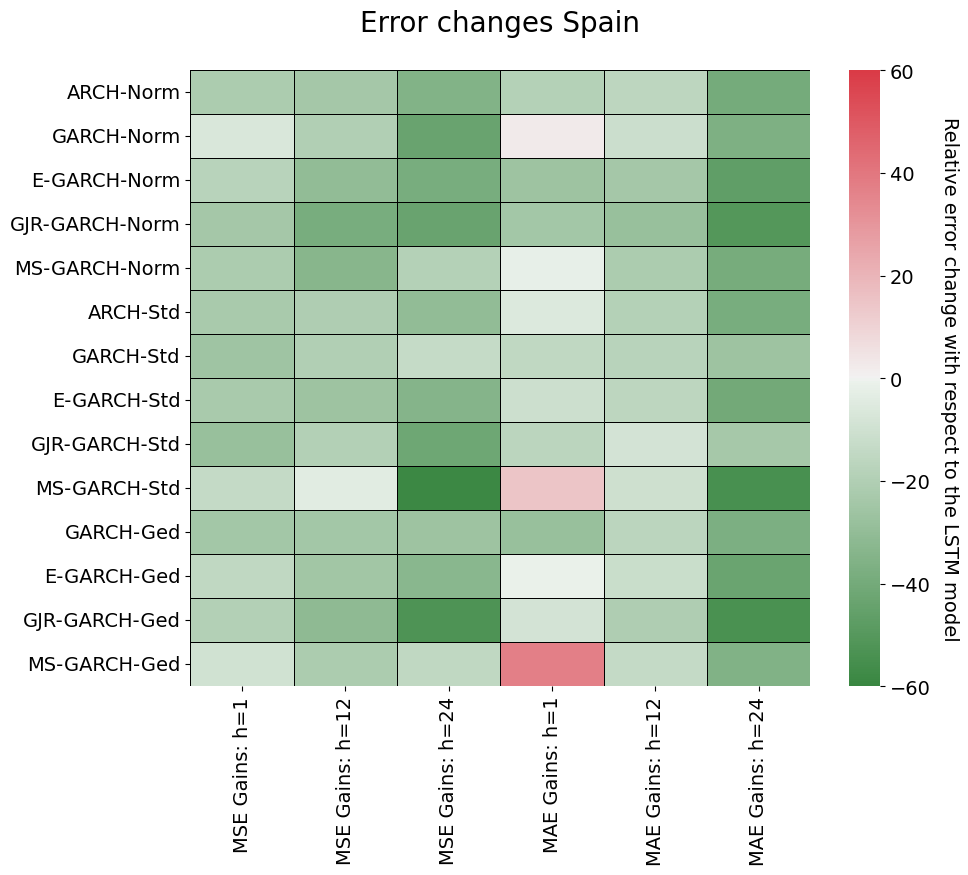

In [158]:
# Benchmarks
mse_gains_lstm_1 = 0
mse_gains_lstm_12 = 0
mse_gains_lstm_24 = 0

mae_gains_lstm_1 = 0
mae_gains_lstm_12 = 0
mae_gains_lstm_24 = 0

# MSE 

# 1-step ahead
mse_gains_lstm_arch_norm_1 = 100*(mse_lstm_arch_norm_1 - mse_lstm_1)/mse_lstm_1
mse_gains_lstm_garch_norm_1 = 100*(mse_lstm_garch_norm_1 - mse_lstm_1)/mse_lstm_1
mse_gains_lstm_egarch_norm_1 = 100*(mse_lstm_egarch_norm_1 - mse_lstm_1)/mse_lstm_1
mse_gains_lstm_gjrgarch_norm_1 = 100*(mse_lstm_gjrgarch_norm_1 - mse_lstm_1)/mse_lstm_1
mse_gains_lstm_msgarch_norm_1 = 100*(mse_lstm_msgarch_norm_1 - mse_lstm_1)/mse_lstm_1

mse_gains_lstm_arch_std_1 = 100*(mse_lstm_arch_std_1 - mse_lstm_1)/mse_lstm_1
mse_gains_lstm_garch_std_1 = 100*(mse_lstm_garch_std_1 - mse_lstm_1)/mse_lstm_1
mse_gains_lstm_egarch_std_1 = 100*(mse_lstm_egarch_std_1 - mse_lstm_1)/mse_lstm_1
mse_gains_lstm_gjrgarch_std_1 = 100*(mse_lstm_gjrgarch_std_1 - mse_lstm_1)/mse_lstm_1
mse_gains_lstm_msgarch_std_1 = 100*(mse_lstm_msgarch_std_1 - mse_lstm_1)/mse_lstm_1

mse_gains_lstm_arch_ged_1 = 100*(mse_lstm_arch_ged_1 - mse_lstm_1)/mse_lstm_1
mse_gains_lstm_garch_ged_1 = 100*(mse_lstm_garch_ged_1 - mse_lstm_1)/mse_lstm_1
mse_gains_lstm_egarch_ged_1 = 100*(mse_lstm_egarch_ged_1 - mse_lstm_1)/mse_lstm_1
mse_gains_lstm_gjrgarch_ged_1 = 100*(mse_lstm_gjrgarch_ged_1 - mse_lstm_1)/mse_lstm_1
mse_gains_lstm_msgarch_ged_1 = 100*(mse_lstm_msgarch_ged_1 - mse_lstm_1)/mse_lstm_1

# 12-step ahead
mse_gains_lstm_arch_norm_12 = 100*(mse_lstm_arch_norm_12 - mse_lstm_12)/mse_lstm_12
mse_gains_lstm_garch_norm_12 = 100*(mse_lstm_garch_norm_12 - mse_lstm_12)/mse_lstm_12
mse_gains_lstm_egarch_norm_12 = 100*(mse_lstm_egarch_norm_12 - mse_lstm_12)/mse_lstm_12
mse_gains_lstm_gjrgarch_norm_12 = 100*(mse_lstm_gjrgarch_norm_12 - mse_lstm_12)/mse_lstm_12
mse_gains_lstm_msgarch_norm_12 = 100*(mse_lstm_msgarch_norm_12 - mse_lstm_12)/mse_lstm_12

mse_gains_lstm_arch_std_12 = 100*(mse_lstm_arch_std_12 - mse_lstm_12)/mse_lstm_12
mse_gains_lstm_garch_std_12 = 100*(mse_lstm_garch_std_12 - mse_lstm_12)/mse_lstm_12
mse_gains_lstm_egarch_std_12 = 100*(mse_lstm_egarch_std_12 - mse_lstm_12)/mse_lstm_12
mse_gains_lstm_gjrgarch_std_12 = 100*(mse_lstm_gjrgarch_std_12 - mse_lstm_12)/mse_lstm_12
mse_gains_lstm_msgarch_std_12 = 100*(mse_lstm_msgarch_std_12 - mse_lstm_12)/mse_lstm_12

mse_gains_lstm_arch_ged_12 = 100*(mse_lstm_arch_ged_12 - mse_lstm_12)/mse_lstm_12
mse_gains_lstm_garch_ged_12 = 100*(mse_lstm_garch_ged_12 - mse_lstm_12)/mse_lstm_12
mse_gains_lstm_egarch_ged_12 = 100*(mse_lstm_egarch_ged_12 - mse_lstm_12)/mse_lstm_12
mse_gains_lstm_gjrgarch_ged_12 = 100*(mse_lstm_gjrgarch_ged_12 - mse_lstm_12)/mse_lstm_12
mse_gains_lstm_msgarch_ged_12 = 100*(mse_lstm_msgarch_ged_12 - mse_lstm_12)/mse_lstm_12

# 24-step ahead
mse_gains_lstm_arch_norm_24 = 100*(mse_lstm_arch_norm_24 - mse_lstm_24)/mse_lstm_24
mse_gains_lstm_garch_norm_24 = 100*(mse_lstm_garch_norm_24 - mse_lstm_24)/mse_lstm_24
mse_gains_lstm_egarch_norm_24 = 100*(mse_lstm_egarch_norm_24 - mse_lstm_24)/mse_lstm_24
mse_gains_lstm_gjrgarch_norm_24 = 100*(mse_lstm_gjrgarch_norm_24 - mse_lstm_24)/mse_lstm_24
mse_gains_lstm_msgarch_norm_24 = 100*(mse_lstm_msgarch_norm_24 - mse_lstm_24)/mse_lstm_24

mse_gains_lstm_arch_std_24 = 100*(mse_lstm_arch_std_24 - mse_lstm_24)/mse_lstm_24
mse_gains_lstm_garch_std_24 = 100*(mse_lstm_garch_std_24 - mse_lstm_24)/mse_lstm_24
mse_gains_lstm_egarch_std_24 = 100*(mse_lstm_egarch_std_24 - mse_lstm_24)/mse_lstm_24
mse_gains_lstm_gjrgarch_std_24 = 100*(mse_lstm_gjrgarch_std_24 - mse_lstm_24)/mse_lstm_24
mse_gains_lstm_msgarch_std_24 = 100*(mse_lstm_msgarch_std_24 - mse_lstm_24)/mse_lstm_24

mse_gains_lstm_arch_ged_24 = 100*(mse_lstm_arch_ged_24 - mse_lstm_24)/mse_lstm_24
mse_gains_lstm_garch_ged_24 = 100*(mse_lstm_garch_ged_24 - mse_lstm_24)/mse_lstm_24
mse_gains_lstm_egarch_ged_24 = 100*(mse_lstm_egarch_ged_24 - mse_lstm_24)/mse_lstm_24
mse_gains_lstm_gjrgarch_ged_24 = 100*(mse_lstm_gjrgarch_ged_24 - mse_lstm_24)/mse_lstm_24
mse_gains_lstm_msgarch_ged_24 = 100*(mse_lstm_msgarch_ged_24 - mse_lstm_24)/mse_lstm_24

# MAE

# 1-step ahead
mae_gains_lstm_arch_norm_1 = 100*(mae_lstm_arch_norm_1 - mae_lstm_1)/mae_lstm_1
mae_gains_lstm_garch_norm_1 = 100*(mae_lstm_garch_norm_1 - mae_lstm_1)/mae_lstm_1
mae_gains_lstm_egarch_norm_1 = 100*(mae_lstm_egarch_norm_1 - mae_lstm_1)/mae_lstm_1
mae_gains_lstm_gjrgarch_norm_1 = 100*(mae_lstm_gjrgarch_norm_1 - mae_lstm_1)/mae_lstm_1
mae_gains_lstm_msgarch_norm_1 = 100*(mae_lstm_msgarch_norm_1 - mae_lstm_1)/mae_lstm_1
mae_gains_lstm_arch_std_1 = 100*(mae_lstm_arch_std_1 - mae_lstm_1)/mae_lstm_1
mae_gains_lstm_garch_std_1 = 100*(mae_lstm_garch_std_1 - mae_lstm_1)/mae_lstm_1
mae_gains_lstm_egarch_std_1 = 100*(mae_lstm_egarch_std_1 - mae_lstm_1)/mae_lstm_1
mae_gains_lstm_gjrgarch_std_1 = 100*(mae_lstm_gjrgarch_std_1 - mae_lstm_1)/mae_lstm_1
mae_gains_lstm_msgarch_std_1 = 100*(mae_lstm_msgarch_std_1 - mae_lstm_1)/mae_lstm_1
mae_gains_lstm_arch_ged_1 = 100*(mae_lstm_arch_ged_1 - mae_lstm_1)/mae_lstm_1
mae_gains_lstm_garch_ged_1 = 100*(mae_lstm_garch_ged_1 - mae_lstm_1)/mae_lstm_1
mae_gains_lstm_egarch_ged_1 = 100*(mae_lstm_egarch_ged_1 - mae_lstm_1)/mae_lstm_1
mae_gains_lstm_gjrgarch_ged_1 = 100*(mae_lstm_gjrgarch_ged_1 - mae_lstm_1)/mae_lstm_1
mae_gains_lstm_msgarch_ged_1 = 100*(mae_lstm_msgarch_ged_1 - mae_lstm_1)/mae_lstm_1

# 12-step ahead
mae_gains_lstm_arch_norm_12 = 100*(mae_lstm_arch_norm_12 - mae_lstm_12)/mae_lstm_12
mae_gains_lstm_garch_norm_12 = 100*(mae_lstm_garch_norm_12 - mae_lstm_12)/mae_lstm_12
mae_gains_lstm_egarch_norm_12 = 100*(mae_lstm_egarch_norm_12 - mae_lstm_12)/mae_lstm_12
mae_gains_lstm_gjrgarch_norm_12 = 100*(mae_lstm_gjrgarch_norm_12 - mae_lstm_12)/mae_lstm_12
mae_gains_lstm_msgarch_norm_12 = 100*(mae_lstm_msgarch_norm_12 - mae_lstm_12)/mae_lstm_12

mae_gains_lstm_arch_std_12 = 100*(mae_lstm_arch_std_12 - mae_lstm_12)/mae_lstm_12
mae_gains_lstm_garch_std_12 = 100*(mae_lstm_garch_std_12 - mae_lstm_12)/mae_lstm_12
mae_gains_lstm_egarch_std_12 = 100*(mae_lstm_egarch_std_12 - mae_lstm_12)/mae_lstm_12
mae_gains_lstm_gjrgarch_std_12 = 100*(mae_lstm_gjrgarch_std_12 - mae_lstm_12)/mae_lstm_12
mae_gains_lstm_msgarch_std_12 = 100*(mae_lstm_msgarch_std_12 - mae_lstm_12)/mae_lstm_12

mae_gains_lstm_arch_ged_12 = 100*(mae_lstm_arch_ged_12 - mae_lstm_12)/mae_lstm_12
mae_gains_lstm_garch_ged_12 = 100*(mae_lstm_garch_ged_12 - mae_lstm_12)/mae_lstm_12
mae_gains_lstm_egarch_ged_12 = 100*(mae_lstm_egarch_ged_12 - mae_lstm_12)/mae_lstm_12
mae_gains_lstm_gjrgarch_ged_12 = 100*(mae_lstm_gjrgarch_ged_12 - mae_lstm_12)/mae_lstm_12
mae_gains_lstm_msgarch_ged_12 = 100*(mae_lstm_msgarch_ged_12 - mae_lstm_12)/mae_lstm_12

# 24-step ahead
mae_gains_lstm_arch_norm_24 = 100*(mae_lstm_arch_norm_24 - mae_lstm_24)/mae_lstm_24
mae_gains_lstm_garch_norm_24 = 100*(mae_lstm_garch_norm_24 - mae_lstm_24)/mae_lstm_24
mae_gains_lstm_egarch_norm_24 = 100*(mae_lstm_egarch_norm_24 - mae_lstm_24)/mae_lstm_24
mae_gains_lstm_gjrgarch_norm_24 = 100*(mae_lstm_gjrgarch_norm_24 - mae_lstm_24)/mae_lstm_24
mae_gains_lstm_msgarch_norm_24 = 100*(mae_lstm_msgarch_norm_24 - mae_lstm_24)/mae_lstm_24

mae_gains_lstm_arch_std_24 = 100*(mae_lstm_arch_std_24 - mae_lstm_24)/mae_lstm_24
mae_gains_lstm_garch_std_24 = 100*(mae_lstm_garch_std_24 - mae_lstm_24)/mae_lstm_24
mae_gains_lstm_egarch_std_24 = 100*(mae_lstm_egarch_std_24 - mae_lstm_24)/mae_lstm_24
mae_gains_lstm_gjrgarch_std_24 = 100*(mae_lstm_gjrgarch_std_24 - mae_lstm_24)/mae_lstm_24
mae_gains_lstm_msgarch_std_24 = 100*(mae_lstm_msgarch_std_24 - mae_lstm_24)/mae_lstm_24

mae_gains_lstm_arch_ged_24 = 100*(mae_lstm_arch_ged_24 - mae_lstm_24)/mae_lstm_24
mae_gains_lstm_garch_ged_24 = 100*(mae_lstm_garch_ged_24 - mae_lstm_24)/mae_lstm_24
mae_gains_lstm_egarch_ged_24 = 100*(mae_lstm_egarch_ged_24 - mae_lstm_24)/mae_lstm_24
mae_gains_lstm_gjrgarch_ged_24 = 100*(mae_lstm_gjrgarch_ged_24 - mae_lstm_24)/mae_lstm_24
mae_gains_lstm_msgarch_ged_24 = 100*(mae_lstm_msgarch_ged_24 - mae_lstm_24)/mae_lstm_24


heatmap_data = {
    'Distribution': ['Normal', 'Normal', 'Normal', 'Normal', 'Normal',  
                      'Student-t', 'Student-t', 'Student-t', 'Student-t', 'Student-t',
                      'GED', 'GED', 'GED', 'GED'],
    'Model:': ['ARCH', 'GARCH', 'E-GARCH', 'GJR-GARCH', 'MS-GARCH',
                'ARCH', 'GARCH', 'E-GARCH', 'GJR-GARCH', 'MS-GARCH',
                'GARCH', 'E-GARCH', 'GJR-GARCH', 'MS-GARCH'],
  'MSE Gains: h=1': [mse_gains_lstm_arch_norm_1, mse_gains_lstm_garch_norm_1, mse_gains_lstm_egarch_norm_1, mse_gains_lstm_gjrgarch_norm_1, mse_gains_lstm_msgarch_norm_1, 
                  mse_gains_lstm_arch_std_1, mse_gains_lstm_garch_std_1, mse_gains_lstm_egarch_std_1, mse_gains_lstm_gjrgarch_std_1, mse_gains_lstm_msgarch_std_1,
                  mse_gains_lstm_garch_ged_1, mse_gains_lstm_egarch_ged_1, mse_gains_lstm_gjrgarch_ged_1, mse_gains_lstm_msgarch_ged_1],
  'MSE Gains: h=12': [mse_gains_lstm_arch_norm_12, mse_gains_lstm_garch_norm_12, mse_gains_lstm_egarch_norm_12, mse_gains_lstm_gjrgarch_norm_12, mse_gains_lstm_msgarch_norm_12, 
                   mse_gains_lstm_arch_std_12, mse_gains_lstm_garch_std_12, mse_gains_lstm_egarch_std_12, mse_gains_lstm_gjrgarch_std_12, mse_gains_lstm_msgarch_std_12,
                   mse_gains_lstm_garch_ged_12, mse_gains_lstm_egarch_ged_12, mse_gains_lstm_gjrgarch_ged_12, mse_gains_lstm_msgarch_ged_12],
  'MSE Gains: h=24': [mse_gains_lstm_arch_norm_24, mse_gains_lstm_garch_norm_24, mse_gains_lstm_egarch_norm_24, mse_gains_lstm_gjrgarch_norm_24, mse_gains_lstm_msgarch_norm_24, 
                  mse_gains_lstm_arch_std_24, mse_gains_lstm_garch_std_24, mse_gains_lstm_egarch_std_24, mse_gains_lstm_gjrgarch_std_24, mse_gains_lstm_msgarch_std_24,
                  mse_gains_lstm_garch_ged_24, mse_gains_lstm_egarch_ged_24, mse_gains_lstm_gjrgarch_ged_24, mse_gains_lstm_msgarch_ged_24],
     'MAE Gains: h=1': [mae_gains_lstm_arch_norm_1, mae_gains_lstm_garch_norm_1, mae_gains_lstm_egarch_norm_1, mae_gains_lstm_gjrgarch_norm_1, mae_gains_lstm_msgarch_norm_1, 
                  mae_gains_lstm_arch_std_1, mae_gains_lstm_garch_std_1, mae_gains_lstm_egarch_std_1, mae_gains_lstm_gjrgarch_std_1, mae_gains_lstm_msgarch_std_1,
                  mae_gains_lstm_garch_ged_1, mae_gains_lstm_egarch_ged_1, mae_gains_lstm_gjrgarch_ged_1, mae_gains_lstm_msgarch_ged_1],
  'MAE Gains: h=12': [mae_gains_lstm_arch_norm_12, mae_gains_lstm_garch_norm_12, mae_gains_lstm_egarch_norm_12, mae_gains_lstm_gjrgarch_norm_12, mae_gains_lstm_msgarch_norm_12, 
                  mae_gains_lstm_arch_std_12, mae_gains_lstm_garch_std_12, mae_gains_lstm_egarch_std_12, mae_gains_lstm_gjrgarch_std_12, mae_gains_lstm_msgarch_std_12,
                  mae_gains_lstm_garch_ged_12, mae_gains_lstm_egarch_ged_12, mae_gains_lstm_gjrgarch_ged_12, mae_gains_lstm_msgarch_ged_12],
  'MAE Gains: h=24': [mae_gains_lstm_arch_norm_24, mae_gains_lstm_garch_norm_24, mae_gains_lstm_egarch_norm_24, mae_gains_lstm_gjrgarch_norm_24, mae_gains_lstm_msgarch_norm_24, 
                  mae_gains_lstm_arch_std_24, mae_gains_lstm_garch_std_24, mae_gains_lstm_egarch_std_24, mae_gains_lstm_gjrgarch_std_24, mae_gains_lstm_msgarch_std_24,
                  mae_gains_lstm_garch_ged_24, mae_gains_lstm_egarch_ged_24, mae_gains_lstm_gjrgarch_ged_24, mae_gains_lstm_msgarch_ged_24],
}

heatmap_df = pd.DataFrame(heatmap_data)

print(heatmap_df)

df_dropped = heatmap_df.drop('Distribution', axis=1)
df_dropped = df_dropped.drop('Model:', axis=1)

new_labels = [ 'ARCH-Norm', 'GARCH-Norm', 'E-GARCH-Norm', 'GJR-GARCH-Norm', 'MS-GARCH-Norm',
                 'ARCH-Std', 'GARCH-Std', 'E-GARCH-Std', 'GJR-GARCH-Std', 'MS-GARCH-Std',
                'GARCH-Ged', 'E-GARCH-Ged', 'GJR-GARCH-Ged', 'MS-GARCH-Ged']  # Replace with your actual labels

df_dropped = pd.DataFrame(df_dropped)

# Create a colormap from green to white to red
cmap = sns.diverging_palette(130, 10, as_cmap=True) 

plt.figure(figsize=(10, 8)) # Change the size of the figure as needed

ax = sns.heatmap(df_dropped, cmap=cmap, center=0, annot=False, linewidths=0.5, linecolor='black', vmin=-60, vmax=60)

cbar = ax.collections[0].colorbar

cbar.set_label('Relative error change with respect to the LSTM model', rotation=270, labelpad=20)


# Set y-tick labels
ax.set_yticklabels(new_labels, rotation=0) # Change rotation as needed

# Set title
plt.title('Error changes Spain', fontsize=20, y=1.05)

plt.show()

## Export to LaTex 

In [87]:
# Create a function to round each entry to the 6th decimal place
def round_to_6_decimals(value):
    return round(value, 7)

# Specify the column names to be rounded
columns_to_round = ['MSE_h=1', 'MSE_h=12', 'MSE_h=24','MAE_h=1', 'MAE_h=12', 'MAE_h=24']

# Apply the rounding function only to the selected columns
rounded_df = df.copy()  # Create a copy of the original DataFrame

for column in columns_to_round:
    rounded_df[column] = rounded_df[column].apply(round_to_6_decimals)

In [88]:
# Convert numpy array to LaTeX table
latex_table = tabulate(rounded_df, tablefmt="latex")

print(latex_table)

\begin{tabular}{rllrrrrrr}
\hline
  0 & Normal    & -         & 0.0002801 & 0.0020239 & 0.0058919 & 0.0058175 & 0.0198447 & 0.0487725 \\
  1 & Normal    & ARCH      & 0.0002187 & 0.0015376 & 0.003794  & 0.0047113 & 0.0166631 & 0.0293717 \\
  2 & Normal    & GARCH     & 0.0002613 & 0.0016249 & 0.0032968 & 0.0059631 & 0.0176057 & 0.0308229 \\
  3 & Normal    & E-GARCH   & 0.0002307 & 0.0014088 & 0.0035952 & 0.0042802 & 0.0150737 & 0.0258502 \\
  4 & Normal    & GJR-GARCH & 0.0002127 & 0.0012452 & 0.0033114 & 0.0043945 & 0.0142512 & 0.0238225 \\
  5 & Normal    & MS-GARCH  & 0.0001266 & 0.0015182 & 0.0024727 & 0.0031279 & 0.0161122 & 0.0251587 \\
  6 & Student-t & -         & 0.0002801 & 0.0020239 & 0.0058919 & 0.0058175 & 0.0198447 & 0.0487725 \\
  7 & Student-t & ARCH      & 0.0002163 & 0.0016041 & 0.0041066 & 0.0054803 & 0.016095  & 0.0297162 \\
  8 & Student-t & GARCH     & 0.0002077 & 0.0016227 & 0.0050935 & 0.0049295 & 0.0163917 & 0.0358328 \\
  9 & Student-t & E-GARCH   & 0.0002168

## 5. Realized volatility predictions

In [42]:
realized_volatility = rv[(len(rv)-obs_test-1):(len(rv)-1)]  # or any other list

In [43]:
rv_12 = []
n = 12 # n-step ahead forecasts

for i, value in enumerate(realized_volatility, start=1):
    if (i - 1) % n == 0:
        rv_12.extend([value]*n)

print(rv_12)

[0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.05153070417515412, 0.05153070417515412, 0.05153070417515412, 0.05153070417515412, 0.05153070417515412, 0.05153070417515412, 0.05153070417515412, 0.05153070417515412, 0.05153070417515412, 0.05153070417515412, 0.05153070417515412, 0.05153070417515412, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.059759401366441874, 0.059759401366441874, 0.059759401366441874, 0.059759401366441874, 0.059759401366441874, 0.059759401366441874, 0.059759401366441874, 0.059759401366441874, 0.059759401366441874, 0.059759401366441874, 0.059759401366441874, 0

In [44]:
rv_24 = []
n = 24 # n-step ahead forecasts

for i, value in enumerate(realized_volatility, start=1):
    if (i - 1) % n == 0:
        rv_24.extend([value]*n)

[0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.07250984238193045, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.05659065196214408, 0.0565906519

In [48]:
print('1-step ahead forecast')
print(mse(rv[(len(rv)-obs_test-1):(len(rv)-1)], rv[len(rv)-obs_test:]))
print(mae(rv[(len(rv)-obs_test-1):(len(rv)-1)], rv[len(rv)-obs_test:]))
print('12-step ahead forecast')
print(mse(rv_12[:-4], rv[len(rv)-obs_test:]))
print(mae(rv_12[:-4], rv[len(rv)-obs_test:]))
print('24-step ahead forecast')
print(mse(rv_24[:-16], rv[len(rv)-obs_test:]))
print(mae(rv_24[:-16], rv[len(rv)-obs_test:]))

1-step ahead forecast
0.0001768543161751787
0.003037674149914218
12-step ahead forecast
0.0022624861758496263
0.016875724355353533
24-step ahead forecast
0.005369581373628695
0.029573990302625957


# 6. Visualizations

In [17]:
dates = pd.read_csv('1. Electricity price datasets/dates.csv')

In [18]:
dates = dates['Datetime (Local)']

In [19]:
dates = pd.to_datetime(dates)

## 6.1 GARCH-type

### 6.1.1 1-Step ahead

In [20]:
realized_volatility = rv[((len(rv)-20000)):]

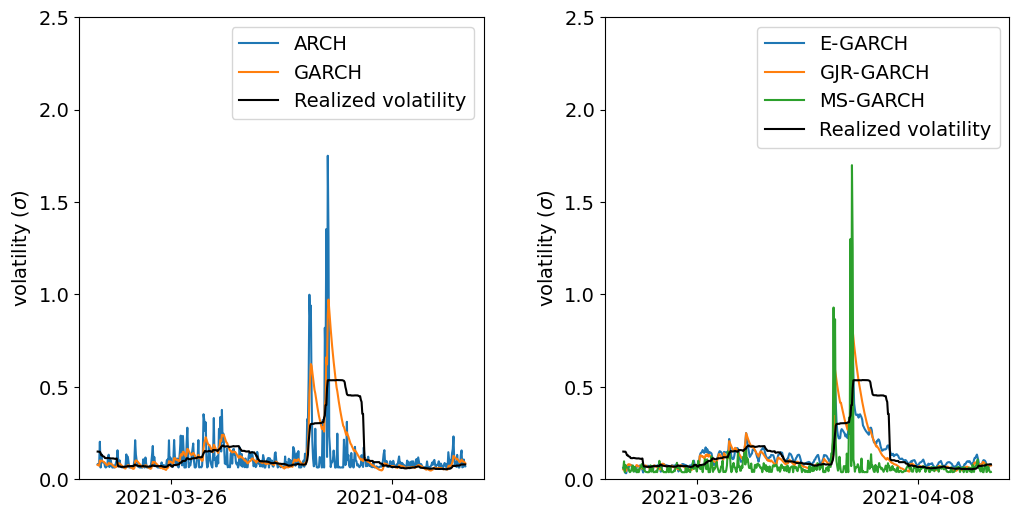

In [133]:
vis = 500
start = 3000
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with 1 row and 2 columns

# Increase global font size
plt.rcParams['font.size'] = '14'  # adjust as needed
interval = 10

# Plot on the first subplot
axs[0].plot(dates[start:(start+vis)], preds_arch_norm_1[start:(start+vis)].values, label='ARCH')
axs[0].plot(dates[start:(start+vis)], preds_garch_norm_1[start:(start+vis)].values, label='GARCH')
axs[0].plot(dates[start:(start+vis)], realized_volatility[start:(start+vis)], color='#000000', label='Realized volatility')
# Format the x-axis dates
axs[0].xaxis.set_major_locator(mdates.DayLocator(interval = interval))  # Set major ticks every day.
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Set format
axs[0].set_ylabel('volatility ($\sigma$)')

# Plot on the first subplot
axs[1].plot(dates[start:(start+vis)], preds_e_garch_norm_1[start:(start+vis)].values, label='E-GARCH')
axs[1].plot(dates[start:(start+vis)], preds_gjr_garch_norm_1[start:(start+vis)].values, label='GJR-GARCH')
axs[1].plot(dates[start:(start+vis)], preds_ms_garch_norm_1[start:(start+vis)].values, label='MS-GARCH')
axs[1].plot(dates[start:(start+vis)], realized_volatility[start:(start+vis)], color='#000000', label='Realized volatility')
# Format the x-axis dates
axs[1].xaxis.set_major_locator(mdates.DayLocator(interval = interval))  # Set major ticks every day.
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Set format
axs[1].set_ylabel('volatility ($\sigma$)')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Determine the range of dates to be plotted
plot_dates = dates[start:(start+vis)]

# Determine the locations for the x-axis labels. Here I'm setting them at the first, middle, and last dates.
x_ticks = [plot_dates.iloc[100], plot_dates.iloc[400]]

# Set the x-axis labels for each subplot
axs[0].set_xticks(x_ticks)
axs[1].set_xticks(x_ticks)

# Set ylimits
axs[0].set_ylim(0, 2.5)
axs[1].set_ylim(0, 2.5)

# Display the figure
axs[0].legend()
axs[1].legend()

# Save the plot as a PNG file
plt.savefig('3. Figures/Plot_GARCH_1_norm.png', dpi=300)  # Specify the filename and DPI (dots per inch)

plt.show()

### 6.1.2 12-Step ahead

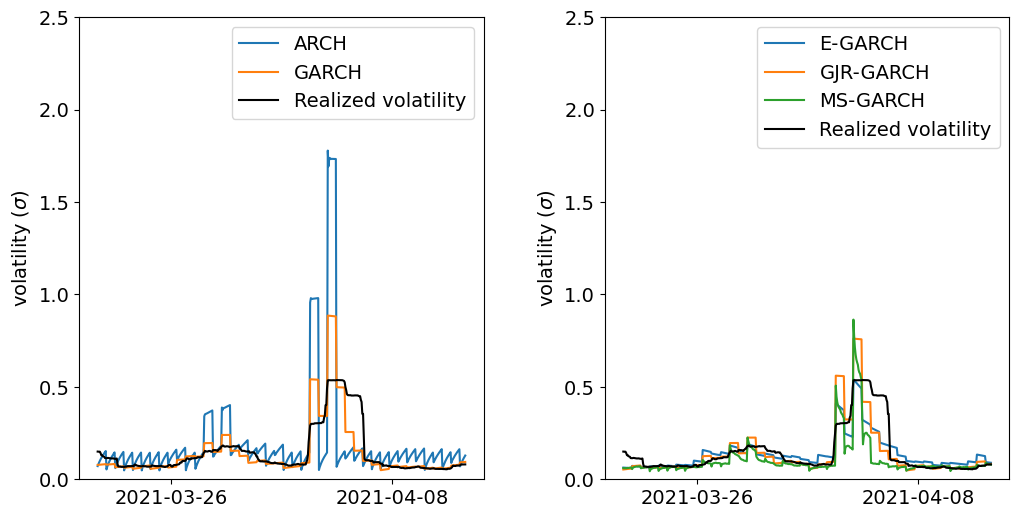

In [130]:
vis = 500
start = 3000
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with 1 row and 2 columns

# Increase global font size
plt.rcParams['font.size'] = '14'  # adjust as needed
interval = 10

# Plot on the first subplot
axs[0].plot(dates[start:(start+vis)], preds_arch_norm_12[start:(start+vis)].values, label='ARCH')
axs[0].plot(dates[start:(start+vis)], preds_garch_norm_12[start:(start+vis)].values, label='GARCH')
axs[0].plot(dates[start:(start+vis)], realized_volatility[start:(start+vis)], color='#000000', label='Realized volatility')
# Format the x-axis dates
axs[0].xaxis.set_major_locator(mdates.DayLocator(interval = interval))  # Set major ticks every day.
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Set format
axs[0].set_ylabel('volatility ($\sigma$)')

# Plot on the first subplot
axs[1].plot(dates[start:(start+vis)], preds_e_garch_norm_12[start:(start+vis)].values, label='E-GARCH')
axs[1].plot(dates[start:(start+vis)], preds_gjr_garch_norm_12[start:(start+vis)].values, label='GJR-GARCH')
axs[1].plot(dates[start:(start+vis)], preds_ms_garch_norm_12[start:(start+vis)].values, label='MS-GARCH')
axs[1].plot(dates[start:(start+vis)], realized_volatility[start:(start+vis)], color='#000000', label='Realized volatility')
# Format the x-axis dates
axs[1].xaxis.set_major_locator(mdates.DayLocator(interval = interval))  # Set major ticks every day.
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Set format
axs[1].set_ylabel('volatility ($\sigma$)')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Determine the range of dates to be plotted
plot_dates = dates[start:(start+vis)]

# Determine the locations for the x-axis labels. Here I'm setting them at the first, middle, and last dates.
x_ticks = [plot_dates.iloc[100], plot_dates.iloc[400]]

# Set the x-axis labels for each subplot
axs[0].set_xticks(x_ticks)
axs[1].set_xticks(x_ticks)

# Set ylimits
axs[0].set_ylim(0, 2.5)
axs[1].set_ylim(0, 2.5)

# Display the figure
axs[0].legend()
axs[1].legend()

# Save the plot as a PNG file
plt.savefig('3. Figures/Plot_GARCH_12_norm.png', dpi=300)  # Specify the filename and DPI (dots per inch)

plt.show()

### 6.1.3 24-Step ahead

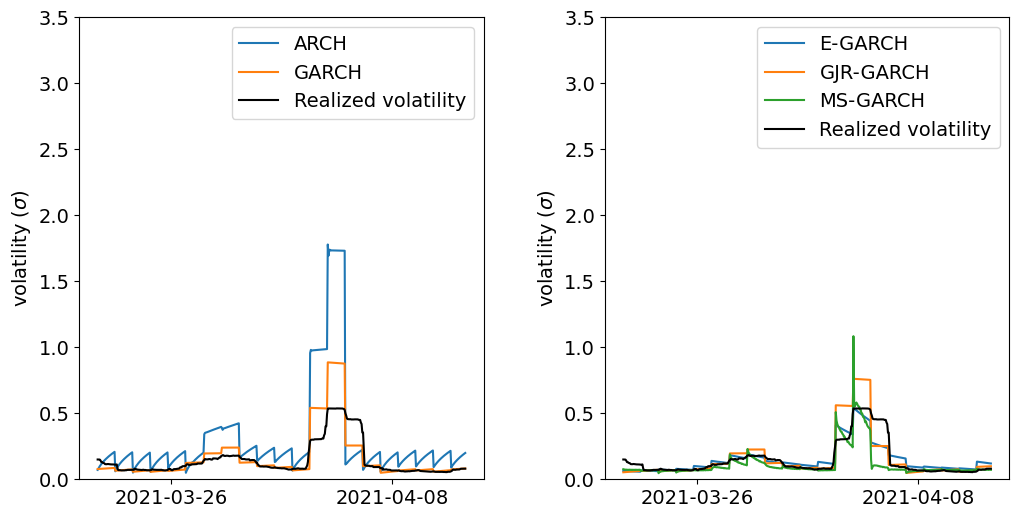

In [128]:
vis = 500
start = 3000
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with 1 row and 2 columns

# Increase global font size
plt.rcParams['font.size'] = '14'  # adjust as needed
interval = 10

# Plot on the first subplot
axs[0].plot(dates[start:(start+vis)], preds_arch_norm_24[start:(start+vis)].values, label='ARCH')
axs[0].plot(dates[start:(start+vis)], preds_garch_norm_24[start:(start+vis)].values, label='GARCH')
axs[0].plot(dates[start:(start+vis)], realized_volatility[start:(start+vis)], color='#000000', label='Realized volatility')
# Format the x-axis dates
axs[0].xaxis.set_major_locator(mdates.DayLocator(interval = interval))  # Set major ticks every day.
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Set format
axs[0].set_ylabel('volatility ($\sigma$)')

# Plot on the first subplot
axs[1].plot(dates[start:(start+vis)], preds_e_garch_norm_24[start:(start+vis)].values, label='E-GARCH')
axs[1].plot(dates[start:(start+vis)], preds_gjr_garch_norm_24[start:(start+vis)].values, label='GJR-GARCH')
axs[1].plot(dates[start:(start+vis)], preds_ms_garch_norm_24[start:(start+vis)].values, label='MS-GARCH')
axs[1].plot(dates[start:(start+vis)], realized_volatility[start:(start+vis)], color='#000000', label='Realized volatility')
# Format the x-axis dates
axs[1].xaxis.set_major_locator(mdates.DayLocator(interval = interval))  # Set major ticks every day.
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Set format
axs[1].set_ylabel('volatility ($\sigma$)')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Determine the range of dates to be plotted
plot_dates = dates[start:(start+vis)]

# Determine the locations for the x-axis labels. Here I'm setting them at the first, middle, and last dates.
x_ticks = [plot_dates.iloc[100], plot_dates.iloc[400]]

# Set the x-axis labels for each subplot
axs[0].set_xticks(x_ticks)
axs[1].set_xticks(x_ticks)

# Set ylimits
axs[0].set_ylim(0, 3.5)
axs[1].set_ylim(0, 3.5)

# Display the figure
axs[0].legend()
axs[1].legend()

# Save the plot as a PNG file
plt.savefig('3. Figures/Plot_GARCH_24_norm.png', dpi=300)  # Specify the filename and DPI (dots per inch)

plt.show()

## 6.2.4 LSTM vs GARCH

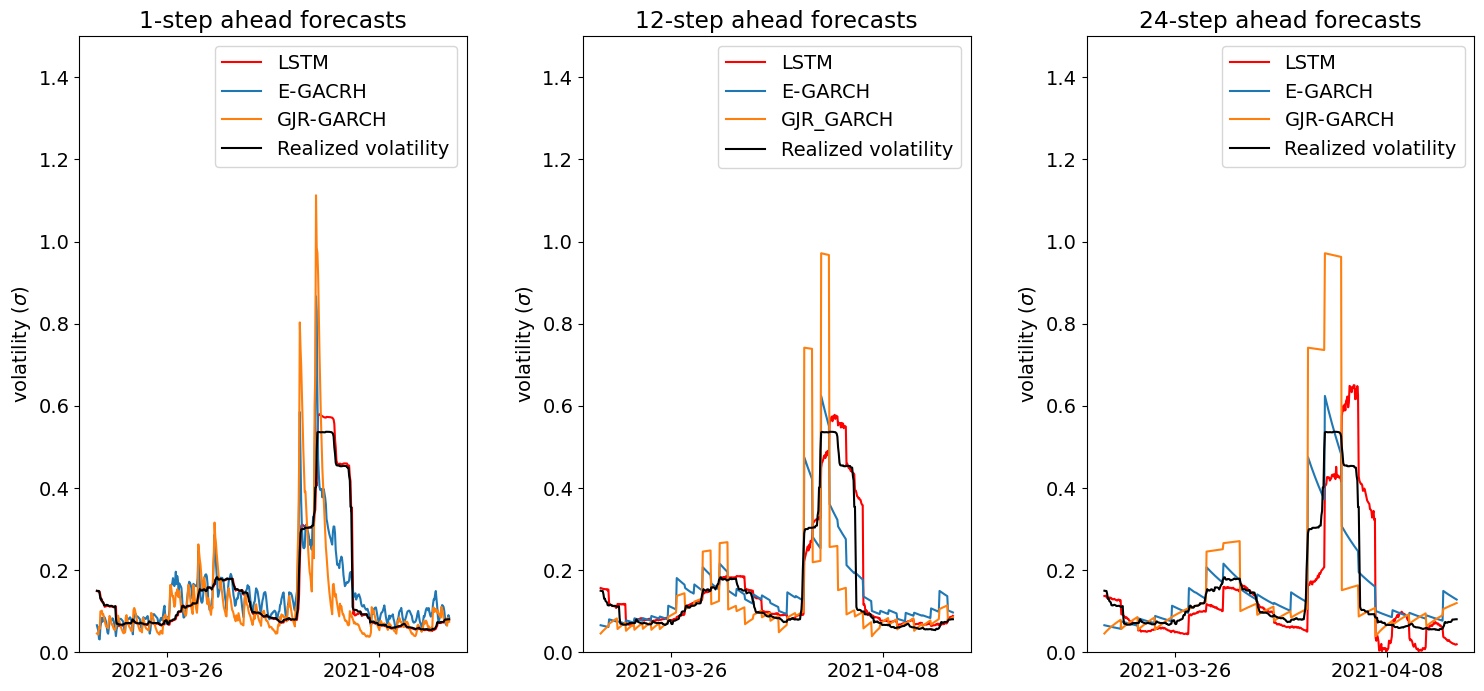

In [127]:
vis = 500
start = 3000
fig, axs = plt.subplots(1, 3, figsize=(18, 8))  # Create a figure with 1 row and 2 columns

# Increase global font size
plt.rcParams['font.size'] = '14'  # adjust as needed
interval = 80

# Plot on the first subplot
axs[0].plot(dates[start:(start+vis)], lstm_preds_1[start:(start+vis)], color='red',  label='LSTM')
axs[0].plot(dates[start:(start+vis)], preds_e_garch_std_1[start:(start+vis)].values, label='E-GACRH')
axs[0].plot(dates[start:(start+vis)], preds_gjr_garch_std_1[start:(start+vis)].values, label='GJR-GARCH')
axs[0].plot(dates[start:(start+vis)], realized_volatility[start:(start+vis)], color='#000000', label='Realized volatility')
# Format the x-axis dates
axs[0].xaxis.set_major_locator(mdates.DayLocator(interval = interval))  # Set major ticks every day.
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Set format
axs[0].set_ylabel('volatility ($\sigma$)')
axs[0].set_title('1-step ahead forecasts')

# Plot on the second subplot (identical to the first subplot)
axs[1].plot(dates[start:(start+vis)], lstm_preds_12[start:(start+vis)], color='red', label='LSTM')
axs[1].plot(dates[start:(start+vis)], preds_e_garch_std_12[start:(start+vis)].values, label='E-GARCH')
axs[1].plot(dates[start:(start+vis)], preds_gjr_garch_std_12[start:(start+vis)].values, label='GJR_GARCH')
axs[1].plot(dates[start:(start+vis)], realized_volatility[start:(start+vis)], color='#000000', label='Realized volatility')
# Format the x-axis dates
axs[1].xaxis.set_major_locator(mdates.DayLocator(interval = interval))  # Set major ticks every day.
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Set format
axs[1].set_ylabel('volatility ($\sigma$)')
axs[1].set_title('12-step ahead forecasts')

# Plot on the second subplot (identical to the first subplot)
axs[2].plot(dates[start:(start+vis)], lstm_preds_24[start:(start+vis)], color='red', label='LSTM')
axs[2].plot(dates[start:(start+vis)], preds_e_garch_std_24[start:(start+vis)].values, label='E-GARCH')
axs[2].plot(dates[start:(start+vis)], preds_gjr_garch_std_24[start:(start+vis)].values, label='GJR-GARCH')
axs[2].plot(dates[start:(start+vis)], realized_volatility[start:(start+vis)], color='#000000', label='Realized volatility')
# Format the x-axis dates
axs[2].xaxis.set_major_locator(mdates.DayLocator(interval = interval))  # Set major ticks every day.
axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Set format
axs[2].set_ylabel('volatility ($\sigma$)')
axs[2].set_title('24-step ahead forecasts')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Determine the range of dates to be plotted
plot_dates = dates[start:(start+vis)]

# Determine the locations for the x-axis labels. Here I'm setting them at the first, middle, and last dates.
x_ticks = [plot_dates.iloc[100], plot_dates.iloc[400]]

# Set the x-axis labels for each subplot
axs[0].set_xticks(x_ticks)
axs[1].set_xticks(x_ticks)
axs[2].set_xticks(x_ticks)

# Set ylimits
axs[0].set_ylim(0, 1.5)
axs[1].set_ylim(0, 1.5)
axs[2].set_ylim(0, 1.5)

# Display the figure
axs[0].legend()
axs[1].legend()
axs[2].legend()

# Export to png
plt.savefig('3. Figures/Plot_LSTM_vs_GARCH_multistep.png', dpi=300)  # Specify the filename and DPI (dots per inch)


plt.show()

## 6.2.3 LSTM vs Hybrid models

## Multi-step ahead

In [93]:
lstm_preds_gjrgarch_norm_12 = np.where(lstm_preds_gjrgarch_norm_12 <= 0.05, 0.05, lstm_preds_gjrgarch_norm_12)
lstm_preds_gjrgarch_norm_24 = np.where(lstm_preds_gjrgarch_norm_24 <= 0.05, 0.05, lstm_preds_gjrgarch_norm_24)

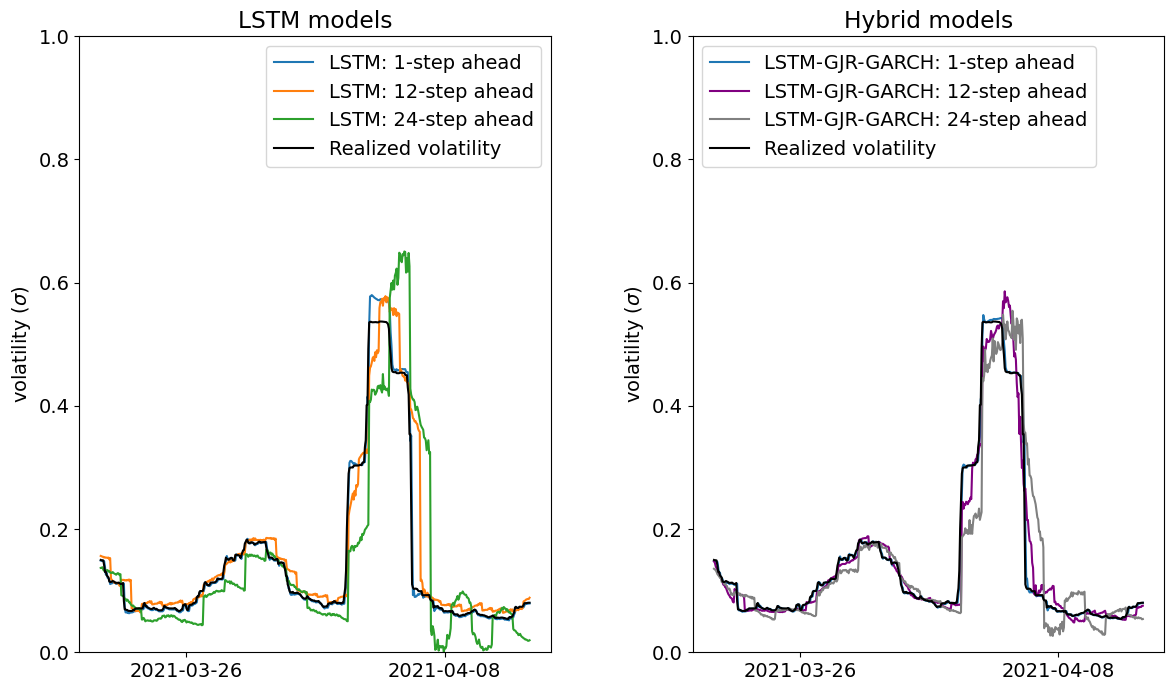

In [122]:
vis = 500
start = 3000
fig, axs = plt.subplots(1, 2, figsize=(14, 8))  # Create a figure with 1 row and 2 columns

# Increase global font size
plt.rcParams['font.size'] = '14'  # adjust as needed
interval = 100

# Plot on the first subplot
axs[0].plot(dates[start:(start+vis)], lstm_preds_1[start:(start+vis)], label='LSTM: 1-step ahead')
axs[0].plot(dates[start:(start+vis)], lstm_preds_12[start:(start+vis)], label='LSTM: 12-step ahead')
axs[0].plot(dates[start:(start+vis)], lstm_preds_24[start:(start+vis)], label='LSTM: 24-step ahead')
axs[0].plot(dates[start:(start+vis)], realized_volatility[start:(start+vis)], color='#000000', label='Realized volatility')
# Format the x-axis dates
axs[0].xaxis.set_major_locator(mdates.DayLocator(interval = interval))  # Set major ticks every day.
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Set format
axs[0].set_ylabel('volatility ($\sigma$)')
axs[0].set_title('LSTM models')

# Plot on the second subplot (identical to the first subplot)
axs[1].plot(dates[start:(start+vis)], lstm_preds_gjrgarch_norm_1[start:(start+vis)], label='LSTM-GJR-GARCH: 1-step ahead')
axs[1].plot(dates[start:(start+vis)], lstm_preds_gjrgarch_norm_12[start:(start+vis)],color='#800080', label='LSTM-GJR-GARCH: 12-step ahead')
axs[1].plot(dates[start:(start+vis)], lstm_preds_gjrgarch_norm_24[start:(start+vis)], color='#808080', label='LSTM-GJR-GARCH: 24-step ahead')
axs[1].plot(dates[start:(start+vis)], realized_volatility[start:(start+vis)], color='#000000', label='Realized volatility')
# Format the x-axis dates
axs[1].xaxis.set_major_locator(mdates.DayLocator(interval = interval))  # Set major ticks every day.
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Set format
axs[1].set_ylabel('volatility ($\sigma$)')
axs[1].set_title('Hybrid models')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Determine the range of dates to be plotted
plot_dates = dates[start:(start+vis)]

# Determine the locations for the x-axis labels. Here I'm setting them at the first, middle, and last dates.
x_ticks = [plot_dates.iloc[100], plot_dates.iloc[400]]

# Set the x-axis labels for each subplot
axs[0].set_xticks(x_ticks)
axs[1].set_xticks(x_ticks)

# Display the figure
axs[0].legend()
axs[1].legend()
axs[1].legend(loc='upper left')

axs[0].set_ylim([0, 1])
axs[1].set_ylim([0, 1])


# Export to png
plt.savefig('3. Figures/Plot_LSTM_vs_Hybrid.png', dpi=300)  # Specify the filename

plt.show()

## LSTM-MS-GARCH models

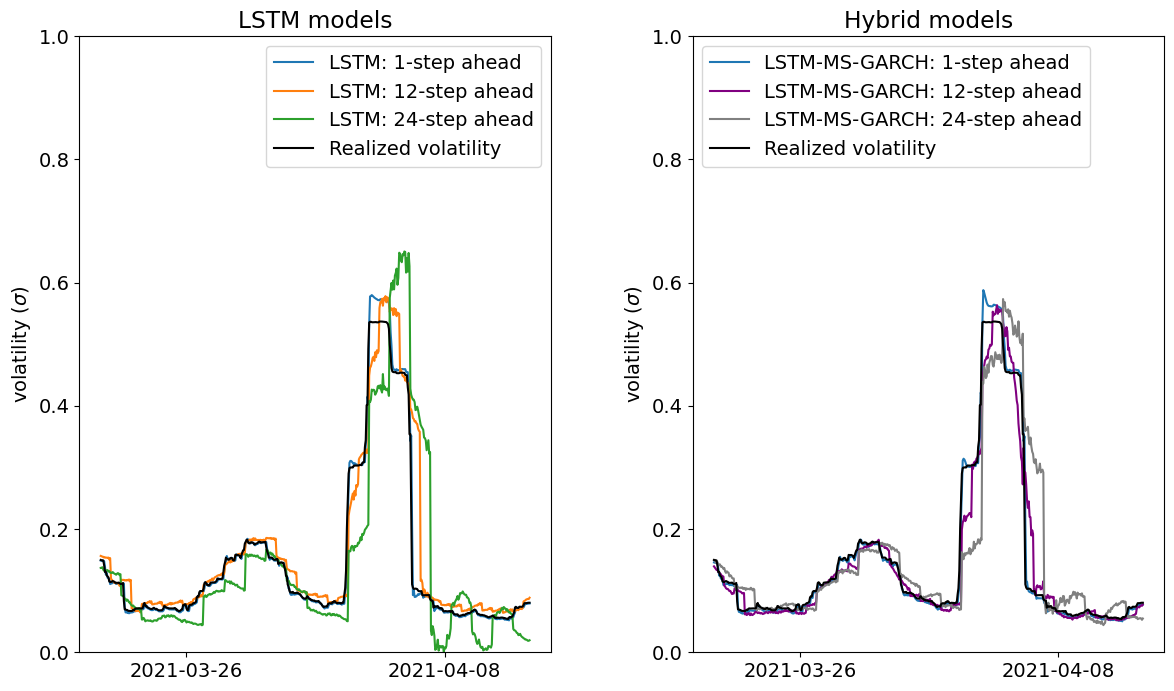

In [124]:
vis = 500
start = 3000
fig, axs = plt.subplots(1, 2, figsize=(14, 8))  # Create a figure with 1 row and 2 columns

# Increase global font size
plt.rcParams['font.size'] = '14'  # adjust as needed
interval = 100

# Plot on the first subplot
axs[0].plot(dates[start:(start+vis)], lstm_preds_1[start:(start+vis)], label='LSTM: 1-step ahead')
axs[0].plot(dates[start:(start+vis)], lstm_preds_12[start:(start+vis)], label='LSTM: 12-step ahead')
axs[0].plot(dates[start:(start+vis)], lstm_preds_24[start:(start+vis)], label='LSTM: 24-step ahead')
axs[0].plot(dates[start:(start+vis)], realized_volatility[start:(start+vis)], color='#000000', label='Realized volatility')
# Format the x-axis dates
axs[0].xaxis.set_major_locator(mdates.DayLocator(interval = interval))  # Set major ticks every day.
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Set format
axs[0].set_ylabel('volatility ($\sigma$)')
axs[0].set_title('LSTM models')

# Plot on the second subplot (identical to the first subplot)
axs[1].plot(dates[start:(start+vis)], lstm_preds_msgarch_norm_1[start:(start+vis)], label='LSTM-MS-GARCH: 1-step ahead')
axs[1].plot(dates[start:(start+vis)], lstm_preds_msgarch_norm_12[start:(start+vis)],color='#800080', label='LSTM-MS-GARCH: 12-step ahead')
axs[1].plot(dates[start:(start+vis)], lstm_preds_msgarch_norm_24[start:(start+vis)], color='#808080', label='LSTM-MS-GARCH: 24-step ahead')
axs[1].plot(dates[start:(start+vis)], realized_volatility[start:(start+vis)], color='#000000', label='Realized volatility')
# Format the x-axis dates
axs[1].xaxis.set_major_locator(mdates.DayLocator(interval = interval))  # Set major ticks every day.
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Set format
axs[1].set_ylabel('volatility ($\sigma$)')
axs[1].set_title('Hybrid models')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Determine the range of dates to be plotted
plot_dates = dates[start:(start+vis)]

# Determine the locations for the x-axis labels. Here I'm setting them at the first, middle, and last dates.
x_ticks = [plot_dates.iloc[100], plot_dates.iloc[400]]

# Set the x-axis labels for each subplot
axs[0].set_xticks(x_ticks)
axs[1].set_xticks(x_ticks)

# Display the figure
axs[0].legend()
axs[1].legend()
axs[1].legend(loc='upper left')

axs[0].set_ylim([0, 1])
axs[1].set_ylim([0, 1])

# Export to png
plt.savefig('3. Figures/Plot_LSTM_vs_LSTM-MS.png', dpi=300)  # Specify the filename

plt.show()

# 7. Residual analysis

## 7.1 1-step ahead residuals

In [37]:
realized_volatility = rv[(len(rv)-20000):]

In [38]:
resid_lstm_preds_1 = lstm_preds_1.squeeze() - realized_volatility
resid_preds_egarch_std_1 = preds_e_garch_std_1.squeeze() - realized_volatility
resid_lstm_preds_gjrgarch_ged_1 = lstm_preds_gjrgarch_ged_1.squeeze() - realized_volatility

## Grid with plot, ACF and histogram

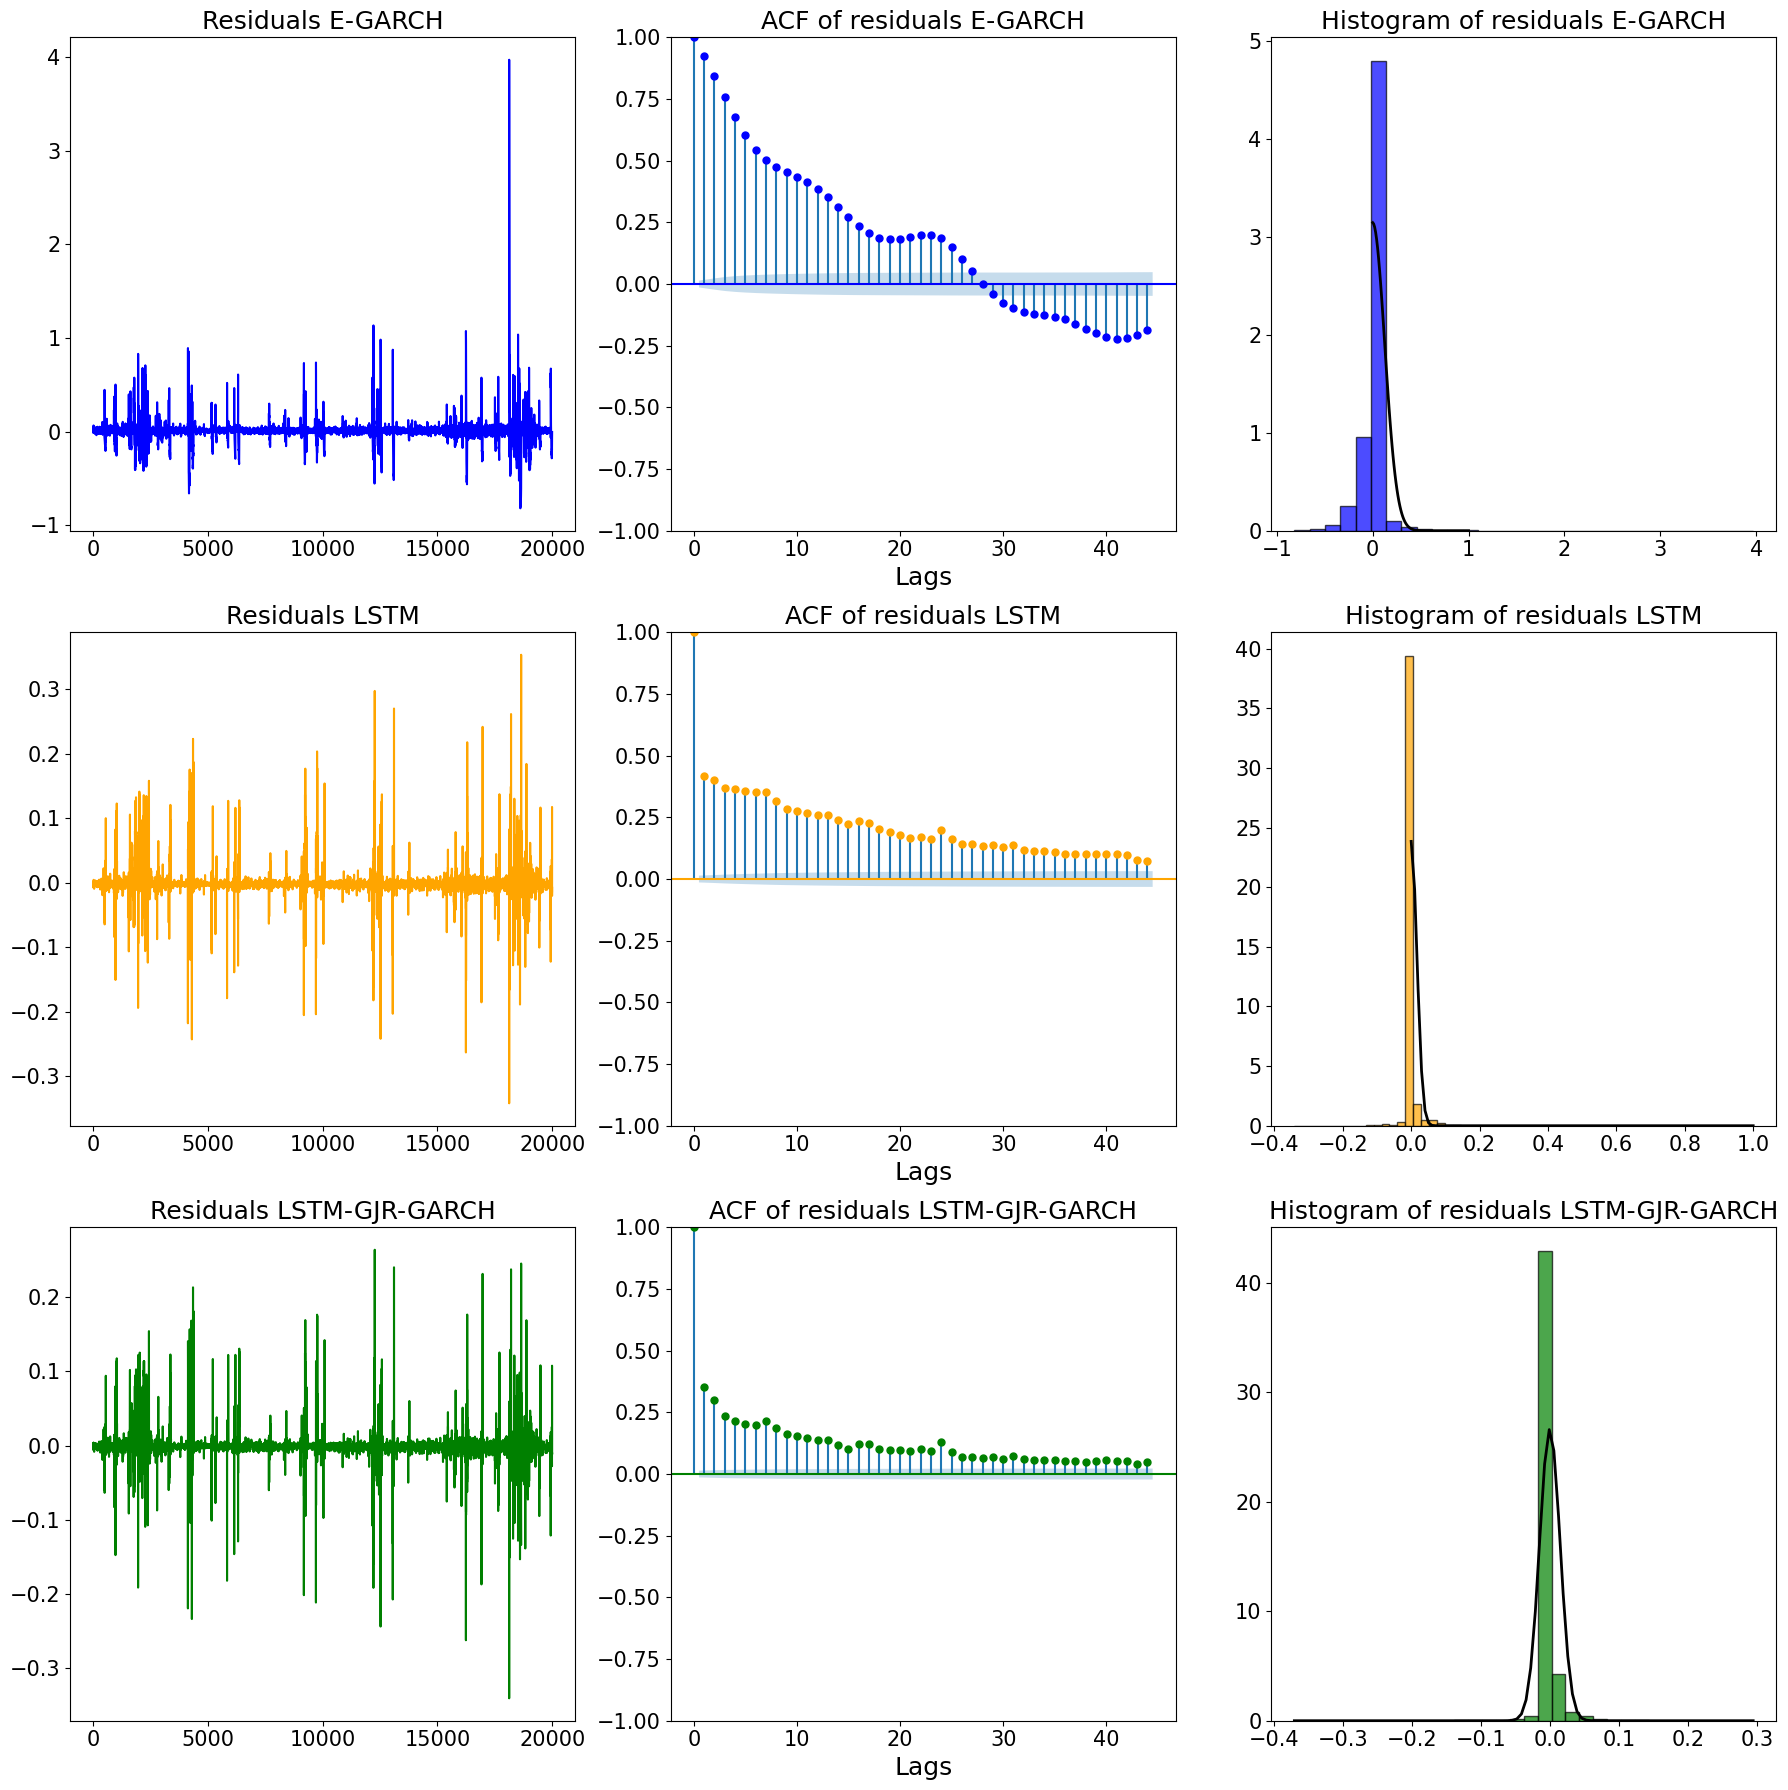

In [39]:
# Create 3 time series
time_series_1 = resid_preds_egarch_std_1
time_series_2 = resid_lstm_preds_1
time_series_3 = resid_lstm_preds_gjrgarch_ged_1

fig, axs = plt.subplots(3, 3, figsize=(18, 18))
fig.subplots_adjust(hspace=2, wspace=1) # Increase vertical space to 2


title_size = 18 # choose your desired title size
tick_size = 15 # choose your desired tick size

# First row
axs[0, 0].plot(time_series_1, color='blue')
axs[0, 0].set_title('Residuals E-GARCH',  fontsize=title_size)
sm.graphics.tsa.plot_acf(time_series_1, ax=axs[0, 1], color='blue')
axs[0, 1].set_title('ACF of residuals E-GARCH',  fontsize=title_size)
axs[0, 2].hist(time_series_1, bins=30, edgecolor='black', alpha=0.7, density=True, color='blue')
mu, std = norm.fit(time_series_1)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
axs[0, 2].plot(x, p, 'k', linewidth=2)
axs[0, 2].set_title('Histogram of residuals E-GARCH',  fontsize=title_size)
axs[0, 0].tick_params(axis='both', which='major', labelsize=tick_size)
axs[0, 1].tick_params(axis='both', which='major', labelsize=tick_size)
axs[0, 2].tick_params(axis='both', which='major', labelsize=tick_size)

# Second row
axs[1, 0].plot(time_series_2, color='orange')
axs[1, 0].set_title('Residuals LSTM',  fontsize=title_size)
sm.graphics.tsa.plot_acf(time_series_2, ax=axs[1, 1], color='orange')
axs[1, 1].set_title('ACF of residuals LSTM',  fontsize=title_size)
axs[1, 2].hist(time_series_2, bins=30, edgecolor='black', alpha=0.7, density=True, color='orange')
mu, std = norm.fit(time_series_2)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
axs[1, 2].plot(x, p, 'k', linewidth=2)
axs[1, 2].set_title('Histogram of residuals LSTM',  fontsize=title_size)
axs[1, 0].tick_params(axis='both', which='major', labelsize=tick_size)
axs[1, 1].tick_params(axis='both', which='major', labelsize=tick_size)
axs[1, 2].tick_params(axis='both', which='major', labelsize=tick_size)

# Third row
axs[2, 0].plot(time_series_3, color='green')
axs[2, 0].set_title('Residuals LSTM-GJR-GARCH',  fontsize=title_size)
sm.graphics.tsa.plot_acf(time_series_3, ax=axs[2, 1], color='green')
axs[2, 1].set_title('ACF of residuals LSTM-GJR-GARCH',  fontsize=title_size)
axs[2, 2].hist(time_series_3, bins=30, edgecolor='black', alpha=0.7, density=True, color='green')
mu, std = norm.fit(time_series_3)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
axs[2, 2].plot(x, p, 'k', linewidth=2)
axs[2, 2].set_title('Histogram of residuals LSTM-GJR-GARCH',  fontsize=title_size)
axs[2, 0].tick_params(axis='both', which='major', labelsize=tick_size)
axs[2, 1].tick_params(axis='both', which='major', labelsize=tick_size)
axs[2, 2].tick_params(axis='both', which='major', labelsize=tick_size)

# Set max ticks
n_ticks_x = 5
axs[0, 0].xaxis.set_major_locator(MaxNLocator(nbins=n_ticks_x))
axs[1, 0].xaxis.set_major_locator(MaxNLocator(nbins=n_ticks_x))
axs[2, 0].xaxis.set_major_locator(MaxNLocator(nbins=n_ticks_x))

axs[0, 1].set_xlabel('Lags', fontsize = 18)
axs[1, 1].set_xlabel('Lags', fontsize = 18)
axs[2, 1].set_xlabel('Lags', fontsize = 18)

fig.subplots_adjust(hspace=1, wspace=1) # wspace for width space
plt.tight_layout()
plt.show()

# 8. ARMA modeling residuals

## 8.1 Out-of-sample residual training 

In [32]:
# Realized volatility
obs_test = 20000
realized_volatility = rv[(len(rv)-obs_test):]

# Take LSTM 1-step ahead as initial model
resid_preds_egarch_norm__1 = preds_e_garch_norm_1.squeeze() - realized_volatility

# Split data into test and training
nobs = len(resid_preds_egarch_norm__1)
n_train = 2000
series_train = resid_preds_egarch_norm__1.iloc[:n_train]

# Fit the model using the training dataset
model = sm.tsa.ARIMA(series_train, order=(5,0,5))
fit = model.fit()

# Compute the first forecast based only on the training dataset
forecasts = []
res = fit
forecasts.append(res.forecast())

# Now step through the test observations:
# (a) add the new observation without refitting the model
# (b) produce a new forecast
for t in tqdm(range(n_train, nobs)):
    # Update the results by appending the next observation
    res = res.append(resid_preds_egarch_norm__1.iloc[t:t + 1], refit=False)
   
    # Produce a forecast for t+1 based on data through t
    forecasts.append(res.forecast())

forecasts = np.array(forecasts[0:(obs_test-n_train)]).squeeze()

y_new_egarch = preds_e_garch_std_1[n_train:obs_test].squeeze() - forecasts

print(mse(preds_e_garch_norm_1[n_train:obs_test], realized_volatility[n_train:obs_test]))
print(mse(y_new_egarch, realized_volatility[n_train:obs_test]))
print(mae(preds_e_garch_norm_1[n_train:obs_test], realized_volatility[n_train:obs_test]))
print(mae(y_new_egarch, realized_volatility[n_train:obs_test]))

/Users/thomasvollebregt/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  0%|          | 0/18000 [00:00<?, ?it/s]

0.01671775306390603
0.002530691408517582
0.05476814094288352
0.01324859737564436


In [33]:
##########

# Realized volatility
obs_test = 20000
realized_volatility = rv[(len(rv)-obs_test):]

# Take LSTM 1-step ahead as initial model
resid_lstm_preds_1 = lstm_preds_1.squeeze() - realized_volatility

# Split data into test and training
nobs = len(resid_lstm_preds_1)
n_train = 2000
series_train = resid_lstm_preds_1.iloc[:n_train]

# Fit the model using the training dataset
model = sm.tsa.ARIMA(series_train, order=(5,0,5))
fit = model.fit()

# Compute the first forecast based only on the training dataset
forecasts = []
res = fit
forecasts.append(res.forecast())

# Now step through the test observations:
# (a) add the new observation without refitting the model
# (b) produce a new forecast
for t in tqdm(range(n_train, nobs)):
    # Update the results by appending the next observation
    res = res.append(resid_lstm_preds_1.iloc[t:t + 1], refit=False)
   
    # Produce a forecast for t+1 based on data through t
    forecasts.append(res.forecast())

forecasts = np.array(forecasts[0:(obs_test-n_train)]).squeeze()

y_new_lstm = lstm_preds_1[n_train:obs_test].squeeze() - forecasts

print(mse(lstm_preds_1[n_train:obs_test], realized_volatility[n_train:obs_test]))
print(mse(y_new_lstm, realized_volatility[n_train:obs_test]))
print(mae(lstm_preds_1[n_train:obs_test], realized_volatility[n_train:obs_test]))
print(mae(y_new_lstm, realized_volatility[n_train:obs_test]))

  0%|          | 0/18000 [00:00<?, ?it/s]

0.0002723325906927889
0.00020224651615085264
0.005682567306520293
0.0044366259318794525


In [54]:
###########

# Realized volatility
obs_test = 20000
realized_volatility = rv[(len(rv)-obs_test):]

# Take LSTM 1-step ahead as initial model
resid_lstm_preds_gjrgarch_std_1 = lstm_preds_gjrgarch_std_1.squeeze() - realized_volatility

# Split data into test and training
nobs = len(resid_lstm_preds_gjrgarch_std_1)
n_train = 2000
series_train = resid_lstm_preds_gjrgarch_std_1.iloc[:n_train]

# Fit the model using the training dataset
model = sm.tsa.ARIMA(series_train, order=(5,0,5))
fit = model.fit()

# Compute the first forecast based only on the training dataset
forecasts = []
res = fit
forecasts.append(res.forecast())

# Now step through the test observations:
# (a) add the new observation without refitting the model
# (b) produce a new forecast
for t in tqdm(range(n_train, nobs)):
    # Update the results by appending the next observation
    res = res.append(resid_lstm_preds_gjrgarch_std_1.iloc[t:t + 1], refit=False)
   
    # Produce a forecast for t+1 based on data through t
    forecasts.append(res.forecast())

forecasts = np.array(forecasts[0:(obs_test-n_train)]).squeeze()

y_new_hybrid = lstm_preds_gjrgarch_std_1[n_train:obs_test].squeeze() - forecasts

print(mse(lstm_preds_gjrgarch_std_1[n_train:obs_test], realized_volatility[n_train:obs_test]))
print(mse(y_new_hybrid, realized_volatility[n_train:obs_test]))
print(mae(lstm_preds_gjrgarch_std_1[n_train:obs_test], realized_volatility[n_train:obs_test]))
print(mae(y_new_hybrid, realized_volatility[n_train:obs_test]))

/Users/thomasvollebregt/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/thomasvollebregt/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/thomasvollebregt/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  0%|          | 0/18000 [00:00<?, ?it/s]

0.0002055967445757187
0.00018809028971043958
0.004858160296950671
0.004241508981007626


## 8.4 Create grid with diagnostic plots

In [655]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import norm

In [55]:
# Create 3 time series
time_series_1 = y_new_egarch - realized_volatility[n_train:obs_test]
time_series_2 = y_new_lstm - realized_volatility[n_train:obs_test]
time_series_3 = y_new_hybrid - realized_volatility[n_train:obs_test]

fig, axs = plt.subplots(3, 3, figsize=(18, 18))

bins = 80
# First row
axs[0, 0].plot(time_series_1, color='blue')
axs[0, 0].set_title('Residuals E-GARCH')
sm.graphics.tsa.plot_acf(time_series_1, ax=axs[0, 1], color='blue')
axs[0, 1].set_title('ACF of residuals E-GARCH')
axs[0, 2].hist(time_series_1, bins=bins, edgecolor='black', alpha=0.7, density=True, color='blue')
mu, std = norm.fit(time_series_1)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
axs[0, 2].plot(x, p, 'k', linewidth=2)
axs[0, 2].set_title('Histogram of residuals E-GARCH')

# Second row
axs[1, 0].plot(time_series_2, color='orange')
axs[1, 0].set_title('Residuals LSTM')
sm.graphics.tsa.plot_acf(time_series_2, ax=axs[1, 1], color='orange')
axs[1, 1].set_title('ACF of residuals LSTM')
axs[1, 2].hist(time_series_2, bins=bins, edgecolor='black', alpha=0.7, density=True, color='orange')
mu, std = norm.fit(time_series_2)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
axs[1, 2].plot(x, p, 'k', linewidth=2)
axs[1, 2].set_title('Histogram of residuals LSTM')

# Third row
axs[2, 0].plot(time_series_3, color='green')
axs[2, 0].set_title('Residuals LSTM-GJR-GARCH')
sm.graphics.tsa.plot_acf(time_series_3, ax=axs[2, 1], color='green')
axs[2, 1].set_title('ACF of residuals LSTM-GJR-GARCH')
axs[2, 2].hist(time_series_3, bins=bins, edgecolor='black', alpha=0.7, density=True, color='green')
mu, std = norm.fit(time_series_3)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
axs[2, 2].plot(x, p, 'k', linewidth=2)
axs[2, 2].set_title('Histogram of residuals LSTM-GJR-GARCH')

fig.subplots_adjust(hspace=0.9)
plt.tight_layout()
plt.show()

NameError: name 'y_new_egarch' is not defined

# 9. Plotting the loss curves

In [666]:
def lstm_model_loss(X_train, y_train, X_val, y_val, verbose, epochs, d, units, nodes, LR, activation_lstm):
    # Define parameters
    verbose, epochs, batch_size = verbose, epochs, d
    n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

    # Define model
    model = Sequential()
    model.add(LSTM(units, activation=activation_lstm, input_shape=(n_timesteps, n_features))) # LSTM units
    model.add(Dense(nodes, activation='relu')) # nodes
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer=Adam(learning_rate = LR))

    # fit network
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_data=(X_val, y_val))

    return model, history

In [667]:
def lstm_model_loss_bivariate(rv_data, filt_data, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h):
   
    scaled_filt = filt_data
    h = h

    X_3D_1 , y_3D_1 = make_supervised(rv_data, obs_test, d, h, 0)    
    X_3D_filt_1, y_3D_filt_1 = make_supervised(scaled_filt, obs_test, d, h, start = 0) #y_3D_filt_1 is not used because the filtered volatility ouputs are not used in training
    
    #Training set 1
    features = 2
    X_3D_2f_1 = np.zeros((X_3D_filt_1.shape[0], X_3D_filt_1.shape[1], features))
    X_3D_1 = np.squeeze(X_3D_1)
    X_3D_filt_1 = np.squeeze(X_3D_filt_1)
    X_3D_2f_1[:,:,0] = X_3D_1
    X_3D_2f_1[:,:,1] = X_3D_filt_1
    
    verbose = 0
    
    #Create validation sets
    X_3D_val, y_3D_val = make_supervised(rv_data, 0, d, h, 0)
    X_3D_val_filt_1, y_3D_val_filt_1 = make_supervised(scaled_filt, 0, d, h, 0)
    
    X_val_2f = X_3D_val[-300:, :, :]
    X__val_filt_2f = X_3D_val_filt_1[-300:, :, :]
    y_val_3D = y_3D_val[-300:, :, :]
    
    #Training set 1
    features = 2
    X_val_2f_3D = np.zeros((X_val_2f.shape[0], X_val_2f.shape[1], features))
    X_val_2f = np.squeeze(X_val_2f)
    X__val_filt_2f = np.squeeze(X__val_filt_2f)
    X_val_2f_3D[:,:,0] = X_val_2f
    X_val_2f_3D[:,:,1] = X__val_filt_2f

    model, history = lstm_model_loss(X_3D_2f_1, y_3D_1, X_val_2f_3D, y_val_3D, verbose, epochs, d, units, nodes, LR, activation_lstm)
    
    return model, history

### LSTM multi-step ahead loss functions

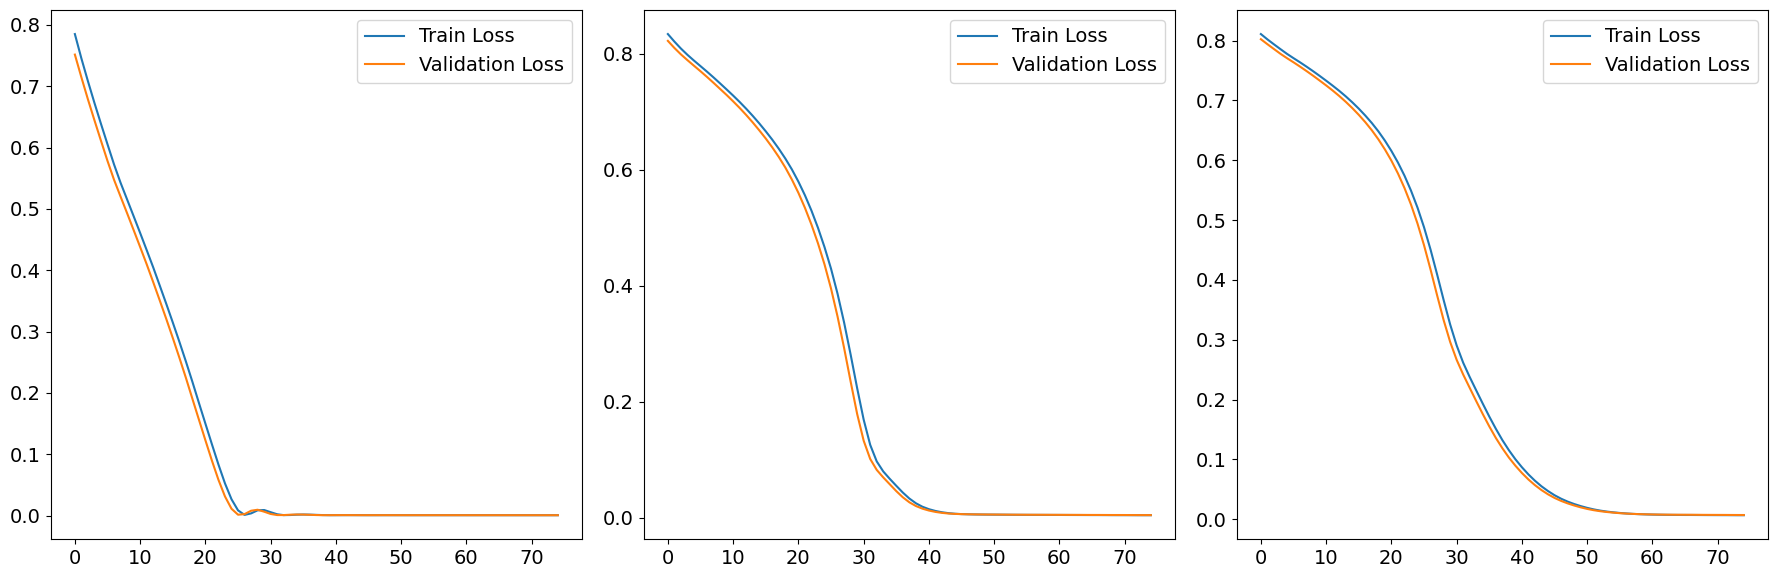

In [682]:
obs_test = 0 
start = 0
h_values = [1, 12, 24]
LR = 0.0001
epochs = 75
obs_test = 20000

fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # create 3 subplots next to each other

for i, h in enumerate(h_values):
    X_3D_val, y_3D_val = make_supervised(scaled_rv, obs_test, d, h, start)
    X_val = X_3D_val[-300:, :, :]
    y_val = y_3D_val[-300:, :, :]
    X_3D, y_3D = make_supervised(scaled_rv, obs_test, d, h, start)
    model, history = lstm_model_loss(X_3D, y_3D, X_val, y_val, verbose, epochs, d, units, nodes, LR, activation_lstm)

    # Plot learning curves on the i-th subplot
    axs[i].plot(history.history['loss'], label='Train Loss')
    axs[i].plot(history.history['val_loss'], label='Validation Loss')
    #axs[i].set_title(f'Loss function for h={h}')
    #axs[i].set_xlabel('Epochs')  # Add label for x-axis
    
    # Increase the size of x and y tick labels
    axes[i].tick_params(axis='x', labelsize=20, rotation=45)  # Increase x-axis label size and rotate labels
    axes[i].tick_params(axis='y', labelsize=2)  # Increase y-axis label size

    # Increase the size of x-label
    axes[i].set_xlabel('Epochs', fontsize=22)  

    # Increase the size of legend
    axes[i].legend(fontsize=17)
    axs[i].legend()

plt.tight_layout()  # adjust subplot parameters to give specified padding
plt.show()

### Hybrid LSTM loss functions

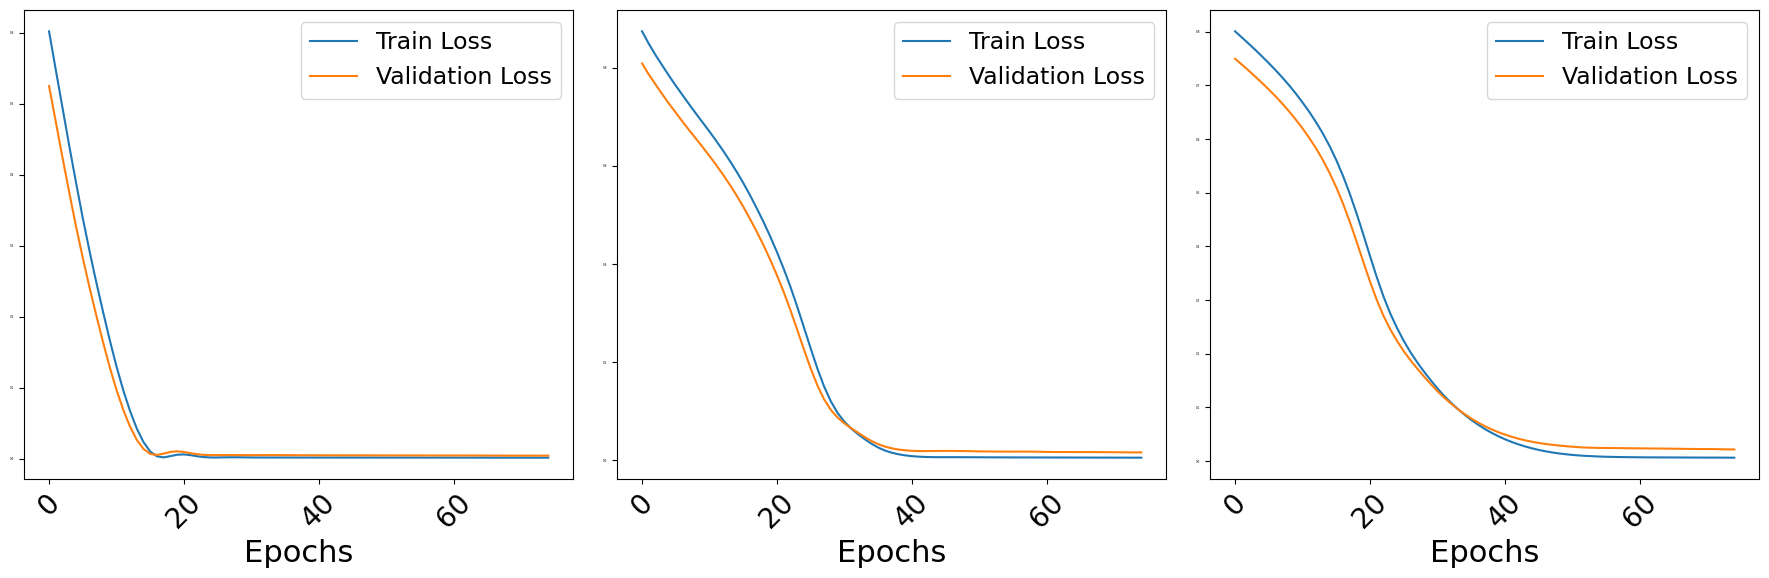

In [680]:
# NEWEST VERSION
LR = 0.0001
epochs = 75
h_values = [1, 12, 24]
rv_data = scaled_rv
filt_data = scaled_data(np.array(feat_e_garch_std_1)).flatten()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))  # Create a figure with three subplots

for i, h in enumerate(h_values):
    obs_test = 20000  # Assuming a certain value for obs_test
    X_3D, y_3D = make_supervised(scaled_rv, obs_test, d, h, start)
    model, history = lstm_model_loss_bivariate(rv_data, filt_data, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h)

    # Plot learning curves on the i-th subplot
    axes[i].plot(history.history['loss'], label='Train Loss')
    axes[i].plot(history.history['val_loss'], label='Validation Loss')

    # Increase the size of x and y tick labels
    axes[i].tick_params(axis='x', labelsize=20, rotation=45)  # Increase x-axis label size and rotate labels
    axes[i].tick_params(axis='y', labelsize=2)  # Increase y-axis label size

    # Increase the size of x-label
    axes[i].set_xlabel('Epochs', fontsize=22)  

    # Increase the size of legend
    axes[i].legend(fontsize=17)

plt.tight_layout()
plt.show()


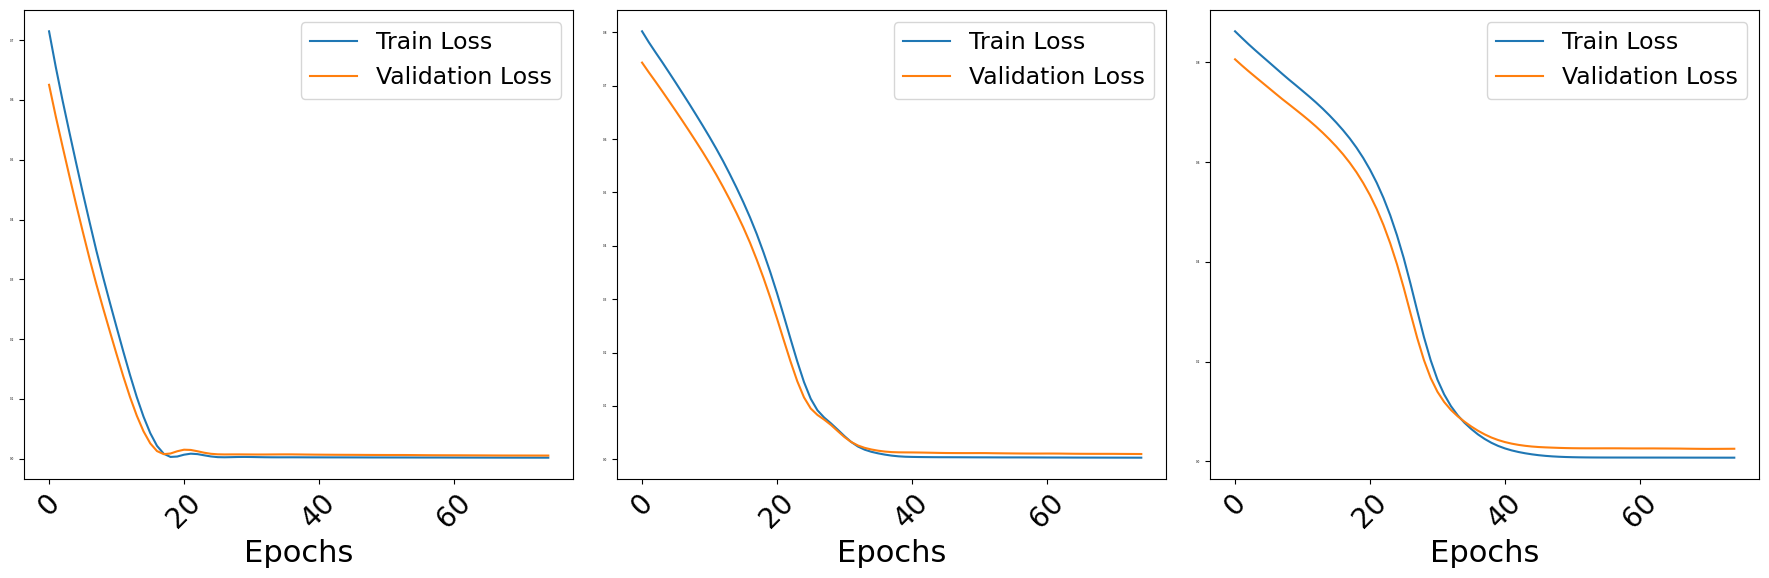

In [681]:
# NEWEST VERSION
LR = 0.0001
epochs = 75
h_values = [1, 12, 24]
rv_data = scaled_rv
filt_data = scaled_data(np.array(feat_gjr_garch_std_1)).flatten()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))  # Create a figure with three subplots

for i, h in enumerate(h_values):
    obs_test = 20000  # Assuming a certain value for obs_test
    X_3D, y_3D = make_supervised(scaled_rv, obs_test, d, h, start)
    model, history = lstm_model_loss_bivariate(rv_data, filt_data, obs_test, start, d, epochs, units, nodes, LR, activation_lstm, rv, h)

    # Plot learning curves on the i-th subplot
    axes[i].plot(history.history['loss'], label='Train Loss')
    axes[i].plot(history.history['val_loss'], label='Validation Loss')

    # Removing the title
    # axes[i].set_title(f'Loss function for h={h}')  # Comment this line

    # Increase the size of x and y tick labels
    axes[i].tick_params(axis='x', labelsize=20, rotation=45)  # Increase x-axis label size and rotate labels
    axes[i].tick_params(axis='y', labelsize=2)  # Increase y-axis label size

    # Increase the size of x-label
    axes[i].set_xlabel('Epochs', fontsize=22)  

    # Increase the size of legend
    axes[i].legend(fontsize=17)

plt.tight_layout()
plt.show()


## 9. Visualizing activation functions

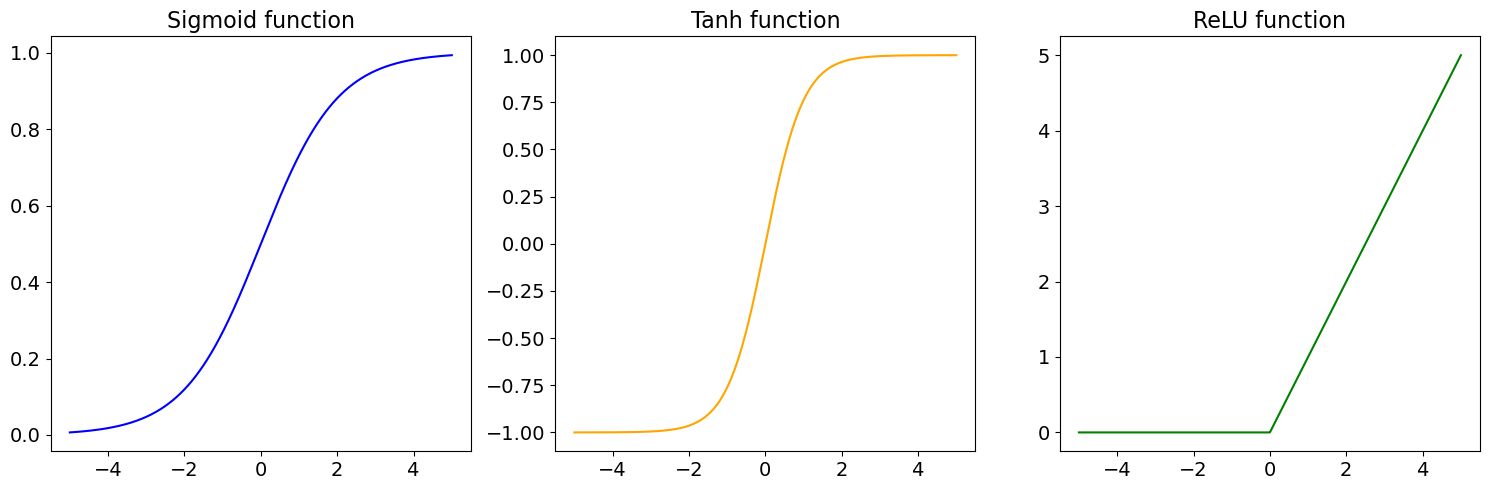

In [237]:
import numpy as np
import matplotlib.pyplot as plt

# Define the functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(0, x)

# Generate a range of values
x = np.linspace(-5, 5, 1000)

# Calculate the function values
y_sigmoid = sigmoid(x)
y_tanh = tanh(x)
y_relu = relu(x)

# Create the plots
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(x, y_sigmoid, color='blue')
plt.title('Sigmoid function', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)

plt.subplot(1, 3, 2)
plt.plot(x, y_tanh, color='orange')
plt.title('Tanh function', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)

plt.subplot(1, 3, 3)
plt.plot(x, y_relu, color='green')
plt.title('ReLU function', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)

# Show the plots
plt.tight_layout()
plt.show()

## 11. Diebold Mariano tests 

In [18]:
real_values = rv[(len(rv)-20000):]

In [19]:
garch_forecasts_1 = [preds_arch_norm_1, preds_arch_std_1, preds_arch_ged_1,
                  preds_garch_norm_1, preds_garch_std_1, preds_garch_ged_1,
                  preds_e_garch_norm_1, preds_e_garch_std_1, preds_e_garch_ged_1,
                  preds_gjr_garch_norm_1, preds_gjr_garch_std_1, preds_gjr_garch_ged_1,
                  preds_ms_garch_norm_1, preds_ms_garch_std_1, preds_ms_garch_ged_1]

In [20]:
garch_forecasts_12 = [preds_arch_norm_12, preds_arch_std_12, preds_arch_ged_12,
                  preds_garch_norm_12, preds_garch_std_12, preds_garch_ged_12,
                  preds_e_garch_norm_12, preds_e_garch_std_12, preds_e_garch_ged_12,
                  preds_gjr_garch_norm_12, preds_gjr_garch_std_12, preds_gjr_garch_ged_12,
                  preds_ms_garch_norm_12, preds_ms_garch_std_12, preds_ms_garch_ged_12]

In [21]:
garch_forecasts_24 = [preds_arch_norm_24, preds_arch_std_24, preds_arch_ged_24,
                  preds_garch_norm_24, preds_garch_std_24, preds_garch_ged_24,
                  preds_e_garch_norm_24, preds_e_garch_std_24, preds_e_garch_ged_24,
                  preds_gjr_garch_norm_24, preds_gjr_garch_std_24, preds_gjr_garch_ged_24,
                  preds_ms_garch_norm_24, preds_ms_garch_std_24, preds_ms_garch_ged_24]

In [22]:
lstm_preds_1 = lstm_preds_1.iloc[:,0]
lstm_preds_arch_norm_1 = lstm_preds_arch_norm_1.iloc[:,0]
lstm_preds_garch_norm_1 = lstm_preds_garch_norm_1.iloc[:,0]
lstm_preds_egarch_norm_1 = lstm_preds_egarch_norm_1.iloc[:,0]
lstm_preds_gjrgarch_norm_1 = lstm_preds_gjrgarch_norm_1.iloc[:,0]
lstm_preds_msgarch_norm_1 = lstm_preds_msgarch_norm_1.iloc[:,0]
lstm_preds_arch_std_1 = lstm_preds_arch_std_1.iloc[:,0]
lstm_preds_garch_std_1 = lstm_preds_garch_std_1.iloc[:,0]
lstm_preds_egarch_std_1 = lstm_preds_egarch_std_1.iloc[:,0]
lstm_preds_gjrgarch_std_1 = lstm_preds_gjrgarch_std_1.iloc[:,0]
lstm_preds_msgarch_std_1 = lstm_preds_msgarch_std_1.iloc[:,0]
lstm_preds_arch_ged_1 = lstm_preds_arch_ged_1.iloc[:,0]
lstm_preds_garch_ged_1 = lstm_preds_garch_ged_1.iloc[:,0]
lstm_preds_egarch_ged_1 = lstm_preds_egarch_ged_1.iloc[:,0]
lstm_preds_gjrgarch_ged_1 = lstm_preds_gjrgarch_ged_1.iloc[:,0]
lstm_preds_msgarch_ged_1 = lstm_preds_msgarch_ged_1.iloc[:,0]

lstm_preds_12 = lstm_preds_12.iloc[:,0]
lstm_preds_arch_norm_12 = lstm_preds_arch_norm_12.iloc[:,0]
lstm_preds_garch_norm_12 = lstm_preds_garch_norm_12.iloc[:,0]
lstm_preds_egarch_norm_12 = lstm_preds_egarch_norm_12.iloc[:,0]
lstm_preds_gjrgarch_norm_12 = lstm_preds_gjrgarch_norm_12.iloc[:,0]
lstm_preds_msgarch_norm_12 = lstm_preds_msgarch_norm_12.iloc[:,0]
lstm_preds_arch_std_12 = lstm_preds_arch_std_12.iloc[:,0]
lstm_preds_garch_std_12 = lstm_preds_garch_std_12.iloc[:,0]
lstm_preds_egarch_std_12 = lstm_preds_egarch_std_12.iloc[:,0]
lstm_preds_gjrgarch_std_12 = lstm_preds_gjrgarch_std_12.iloc[:,0]
lstm_preds_msgarch_std_12 = lstm_preds_msgarch_std_12.iloc[:,0]
lstm_preds_arch_ged_12 = lstm_preds_arch_ged_12.iloc[:,0]
lstm_preds_garch_ged_12 = lstm_preds_garch_ged_12.iloc[:,0]
lstm_preds_egarch_ged_12 = lstm_preds_egarch_ged_12.iloc[:,0]
lstm_preds_gjrgarch_ged_12 = lstm_preds_gjrgarch_ged_12.iloc[:,0]
lstm_preds_msgarch_ged_12 = lstm_preds_msgarch_ged_12.iloc[:,0]

lstm_preds_24 = lstm_preds_24.iloc[:,0]
lstm_preds_arch_norm_24 = lstm_preds_arch_norm_24.iloc[:,0]
lstm_preds_garch_norm_24 = lstm_preds_garch_norm_24.iloc[:,0]
lstm_preds_egarch_norm_24 = lstm_preds_egarch_norm_24.iloc[:,0]
lstm_preds_gjrgarch_norm_24 = lstm_preds_gjrgarch_norm_24.iloc[:,0]
lstm_preds_msgarch_norm_24 = lstm_preds_msgarch_norm_24.iloc[:,0]
lstm_preds_arch_std_24 = lstm_preds_arch_std_24.iloc[:,0]
lstm_preds_garch_std_24 = lstm_preds_garch_std_24.iloc[:,0]
lstm_preds_egarch_std_24 = lstm_preds_egarch_std_24.iloc[:,0]
lstm_preds_gjrgarch_std_24 = lstm_preds_gjrgarch_std_24.iloc[:,0]
lstm_preds_msgarch_std_24 = lstm_preds_msgarch_std_24.iloc[:,0]
lstm_preds_arch_ged_24 = lstm_preds_arch_ged_24.iloc[:,0]
lstm_preds_garch_ged_24 = lstm_preds_garch_ged_24.iloc[:,0]
lstm_preds_egarch_ged_24 = lstm_preds_egarch_ged_24.iloc[:,0]
lstm_preds_gjrgarch_ged_24 = lstm_preds_gjrgarch_ged_24.iloc[:,0]
lstm_preds_msgarch_ged_24 = lstm_preds_msgarch_ged_24.iloc[:,0]

In [23]:
lstm_forecasts_1 = [lstm_preds_1,
                 lstm_preds_arch_norm_1, lstm_preds_arch_std_1, lstm_preds_arch_ged_1,
                 lstm_preds_garch_norm_1, lstm_preds_garch_std_1, lstm_preds_garch_ged_1,
                 lstm_preds_egarch_norm_1, lstm_preds_egarch_std_1, lstm_preds_egarch_ged_1,
                 lstm_preds_gjrgarch_norm_1, lstm_preds_gjrgarch_std_1, lstm_preds_gjrgarch_ged_1,
                 lstm_preds_msgarch_norm_1, lstm_preds_msgarch_std_1, lstm_preds_msgarch_ged_1]

lstm_forecasts_12 = [lstm_preds_12,
                 lstm_preds_arch_norm_12, lstm_preds_arch_std_12, lstm_preds_arch_ged_12,
                 lstm_preds_garch_norm_12, lstm_preds_garch_std_12, lstm_preds_garch_ged_12,
                 lstm_preds_egarch_norm_12, lstm_preds_egarch_std_12, lstm_preds_egarch_ged_12,
                 lstm_preds_gjrgarch_norm_12, lstm_preds_gjrgarch_std_12, lstm_preds_gjrgarch_ged_12,
                 lstm_preds_msgarch_norm_12, lstm_preds_msgarch_std_12, lstm_preds_msgarch_ged_12]

lstm_forecasts_24 = [lstm_preds_24,
                 lstm_preds_arch_norm_24, lstm_preds_arch_std_24, lstm_preds_arch_ged_24,
                 lstm_preds_garch_norm_24, lstm_preds_garch_std_24, lstm_preds_garch_ged_24,
                 lstm_preds_egarch_norm_24, lstm_preds_egarch_std_24, lstm_preds_egarch_ged_24,
                 lstm_preds_gjrgarch_norm_24, lstm_preds_gjrgarch_std_24, lstm_preds_gjrgarch_ged_24,
                 lstm_preds_msgarch_norm_24, lstm_preds_msgarch_std_24, lstm_preds_msgarch_ged_24]

In [30]:
# Create an empty list
comparison_matrix = []

for i in range(16):
    row = []
    for j in range(16):
        if i == j:
            row.append("-")
        else:
            row.append(np.round(dm_test_2_mae(real_values, lstm_forecasts_24[i], lstm_forecasts_24[j], h=24, harvey_adj=True)[1], 3))
    comparison_matrix.append(row)

# Convert list of lists to a numpy array
comparison_matrix = np.array(comparison_matrix)

In [31]:
# Convert numpy array to pandas DataFrame
df = pd.DataFrame(comparison_matrix, columns=['-', 'ARCH-Norm','ARCH-Std','ARCH-Ged', 'GARCH-Norm','GARCH-Std','GARCH-Ged',
                                              'EGARCH-Norm', 'EGARCH-Std','EGARCH-Ged',
                                              'GJR-GARCH-Norm', 'GJR-GARCH-Std', 'GJR-GARCH-Ged',
                                              'MS-GARCH-Norm','MS-GARCH-Std','MS-GARCH-Ged'])

# Convert DataFrame to LaTeX
latex = df.to_latex(index=False)  # Set index=False if you don't want row indices in your LaTeX table

print(latex)

\begin{tabular}{llllllllllllllll}
\toprule
  - & ARCH-Norm & ARCH-Std & ARCH-Ged & GARCH-Norm & GARCH-Std & GARCH-Ged & EGARCH-Norm & EGARCH-Std & EGARCH-Ged & GJR-GARCH-Norm & GJR-GARCH-Std & GJR-GARCH-Ged & MS-GARCH-Norm & MS-GARCH-Std & MS-GARCH-Ged \\
\midrule
  - &       0.0 &      0.0 &      0.0 &        0.0 &       0.0 &       0.0 &         0.0 &        0.0 &        0.0 &            0.0 &           0.0 &           0.0 &           0.0 &          0.0 &          0.0 \\
0.0 &         - &    0.526 &    0.004 &      0.105 &       0.0 &     0.147 &         0.0 &      0.607 &      0.066 &            0.0 &           0.0 &           0.0 &         0.758 &          0.0 &        0.048 \\
0.0 &     0.526 &        - &    0.002 &      0.267 &       0.0 &     0.373 &         0.0 &      0.326 &      0.029 &            0.0 &           0.0 &           0.0 &         0.949 &          0.0 &        0.113 \\
0.0 &     0.004 &    0.002 &        - &      0.135 &     0.007 &     0.013 &         0.0 &      

/var/folders/f4/r997w8nx5v5022dy1nxllgk00000gn/T/ipykernel_69591/1757893423.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = df.to_latex(index=False)  # Set index=False if you don't want row indices in your LaTeX table


In [84]:
# Create an empty list
comparison_matrix = []

for i in range(15):
    row = []
    for j in range(15):
        if i == j:
            row.append("-")
        else:
            row.append(np.round(dm_test_2(real_values, garch_forecasts[i], garch_forecasts[j], h=1, harvey_adj=True)[1], 3))
    comparison_matrix.append(row)

# Convert list of lists to a numpy array
comparison_matrix = np.array(comparison_matrix)

In [86]:
# Convert numpy array to pandas DataFrame
df = pd.DataFrame(comparison_matrix, columns=['Column1', 'Column2', 'Column3','Column1', 'Column2', 'Column3','Column1', 'Column2', 'Column3','Column1', 'Column2', 'Column3','Column1', 'Column2', 'Column3'])

# Convert DataFrame to LaTeX
latex = df.to_latex(index=False)  # Set index=False if you don't want row indices in your LaTeX table

print(latex)

\begin{tabular}{lllllllllllllll}
\toprule
Column1 & Column2 & Column3 & Column1 & Column2 & Column3 & Column1 & Column2 & Column3 & Column1 & Column2 & Column3 & Column1 & Column2 & Column3 \\
\midrule
      - &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 \\
    0.0 &       - &     0.0 &     0.0 &     0.0 &   0.448 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 \\
    0.0 &     0.0 &       - &     0.0 &     0.0 &   0.242 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 \\
    0.0 &     0.0 &     0.0 &       - &     0.0 &     0.0 &   0.068 &   0.183 &   0.818 &    0.02 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 \\
    0.0 &     0.0 &     0.0 &     0.0 &       - &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 &     0.0 \\
    0.0 &   0.448 &   0.242 &     0.0 &    

/var/folders/f4/r997w8nx5v5022dy1nxllgk00000gn/T/ipykernel_39020/2013095257.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = df.to_latex(index=False)  # Set index=False if you don't want row indices in your LaTeX table
